<a href="https://colab.research.google.com/github/k3vin527/project/blob/master/ambulance_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# B반_AI서비스개발PJT_3조(컴퓨터비전2)

### 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 압축파일 해제
from zipfile import ZipFile

with ZipFile('/content/drive/MyDrive/AI 개발 프로젝트/dataset/Ambulance_data.zip') as z: 
    z.extractall()

In [ ]:
# 구글 드라이버로 이동된 dataset 확인
!ls /content/

drive  sample_data  test  train  val


---
---
---
---
---
---

### EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import glob as gb
import tensorflow as tf
import PIL
from PIL import ImageDraw

from keras import models
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense,Flatten,Dense, Activation, BatchNormalization,Input,Add,ZeroPadding2D,AveragePooling2D,GlobalMaxPooling2D,MaxPool2D
from keras import optimizers
from keras import regularizers
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

from sklearn.metrics import confusion_matrix

In [ ]:
filenames_amb = os.listdir('/content/train/ambulance')
filenames_noamb = os.listdir('/content/train/non-ambulance')
amb_df = pd.DataFrame({'filename': filenames_amb, 'label': 'ambulance'})
noamb_df = pd.DataFrame({'filename': filenames_noamb, 'label': 'non-ambulance'})

train_df = pd.concat([amb_df, noamb_df])
train_df

filename          label
0     23WB30G7ILWD.jpg      ambulance
1     MKDYB1LT2LLD.jpg      ambulance
2     P5TFFJ895I9I.jpg      ambulance
3     4JEXTCY067JP.jpg      ambulance
4     3UJ4YSYP6L27.jpg      ambulance
...                ...            ...
1195         04205.jpg  non-ambulance
1196         04194.jpg  non-ambulance
1197         04006.jpg  non-ambulance
1198         04508.jpg  non-ambulance
1199         03661.jpg  non-ambulance

[2400 rows x 2 columns]

In [ ]:
train_df['label'] = train_df['label'].map({'ambulance': '1', 'non-ambulance':'0'})
train_df

filename label
0     23WB30G7ILWD.jpg     1
1     MKDYB1LT2LLD.jpg     1
2     P5TFFJ895I9I.jpg     1
3     4JEXTCY067JP.jpg     1
4     3UJ4YSYP6L27.jpg     1
...                ...   ...
1195         04205.jpg     0
1196         04194.jpg     0
1197         04006.jpg     0
1198         04508.jpg     0
1199         03661.jpg     0

[2400 rows x 2 columns]

In [ ]:
train_df['label'].value_counts()

1    1200
0    1200
Name: label, dtype: int64

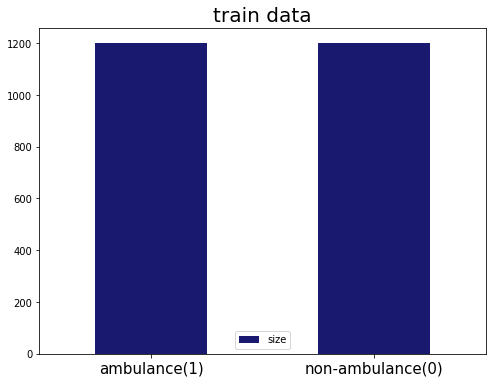

In [ ]:
ambulance = os.listdir('/content/train/ambulance')
non_ambulance = os.listdir('/content/train/non-ambulance')

df1 = pd.DataFrame({'ambulance(1)': [len(ambulance)], 'non-ambulance(0)':[len(non_ambulance)]},
                  index = ['size'])

df1.T.plot(kind='bar',  color='midnightblue', figsize=(8, 6))
plt.xticks(fontsize=15, rotation=0) 
plt.title('train data', size=20)
plt.legend(loc='best')
plt.show()

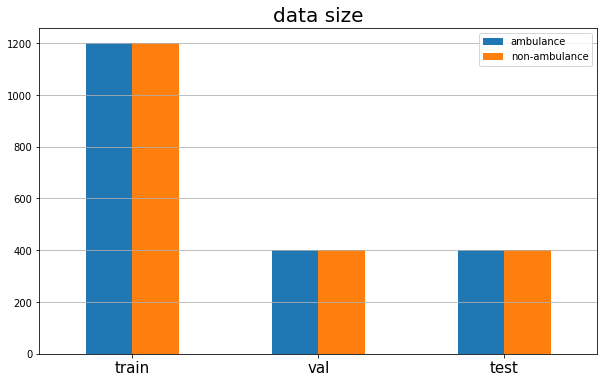

In [ ]:
ambulance = os.listdir('/content/train/ambulance')
non_ambulance = os.listdir('/content/train/non-ambulance')
val_amb = os.listdir('/content/val/ambulance')
val_noamb = os.listdir('/content/val/non-ambulance')
test_amb = os.listdir('/content/test/ambulance')
test_noamb = val_amb = os.listdir('/content/test/non-ambulance')

df2 = pd.DataFrame({'train': [len(ambulance), len(non_ambulance)], 
                    'val':[len(val_amb), len(val_noamb)],
                    'test':[len(test_amb), len(test_noamb)]},
                   index = ['ambulance', 'non-ambulance'])

df2.T.plot(kind='bar', figsize=(10, 6))
plt.xticks(fontsize=15, rotation=0) 
plt.title('data size', size=20)
plt.grid(True,axis='y')
plt.legend(loc='best')
plt.show()

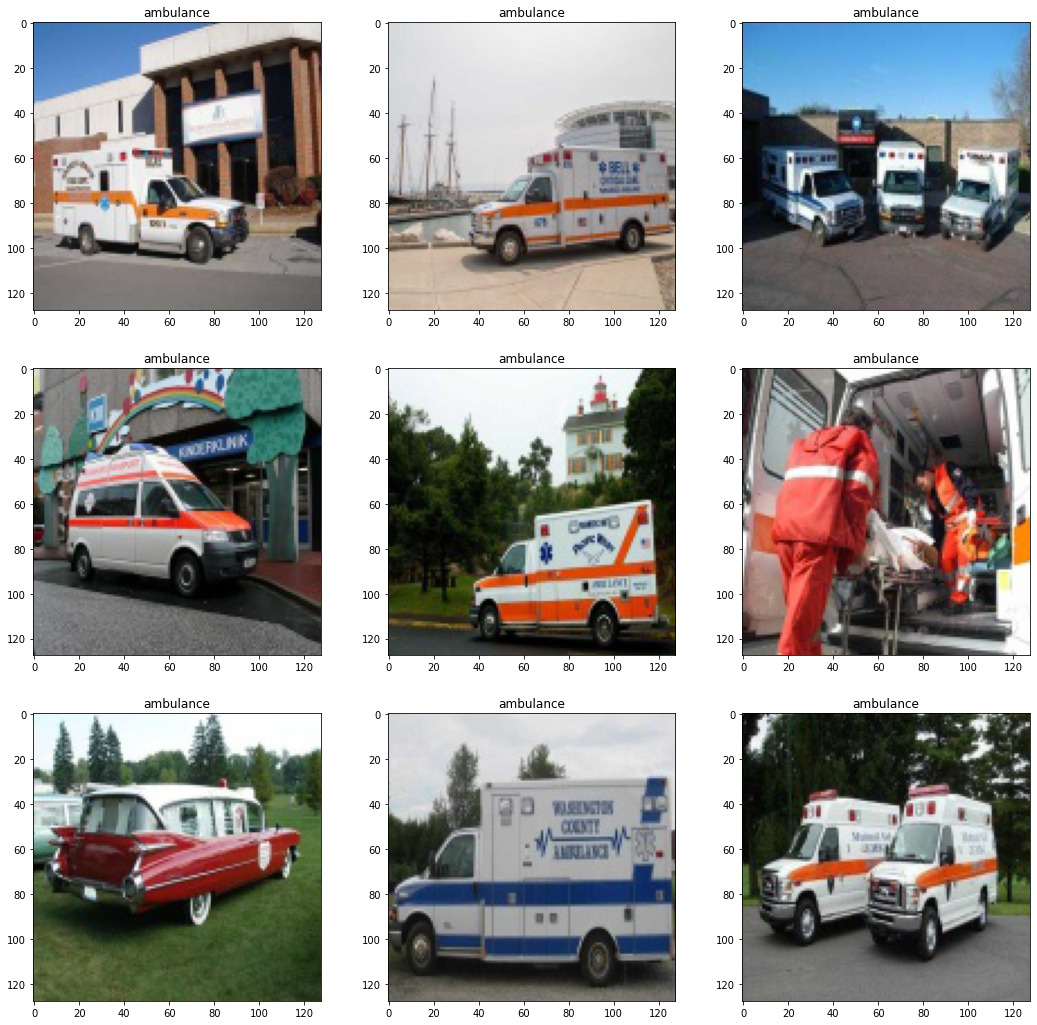

In [ ]:
# train set/ ambulance image 확인

tmp_imgs = train_df['filename'][:9] # image file name
plt.figure(figsize=(18,18))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join('/content/train/ambulance', f_name))

    plt.subplot(3, 3, num + 1)
    plt.title('ambulance')
    plt.imshow(img)

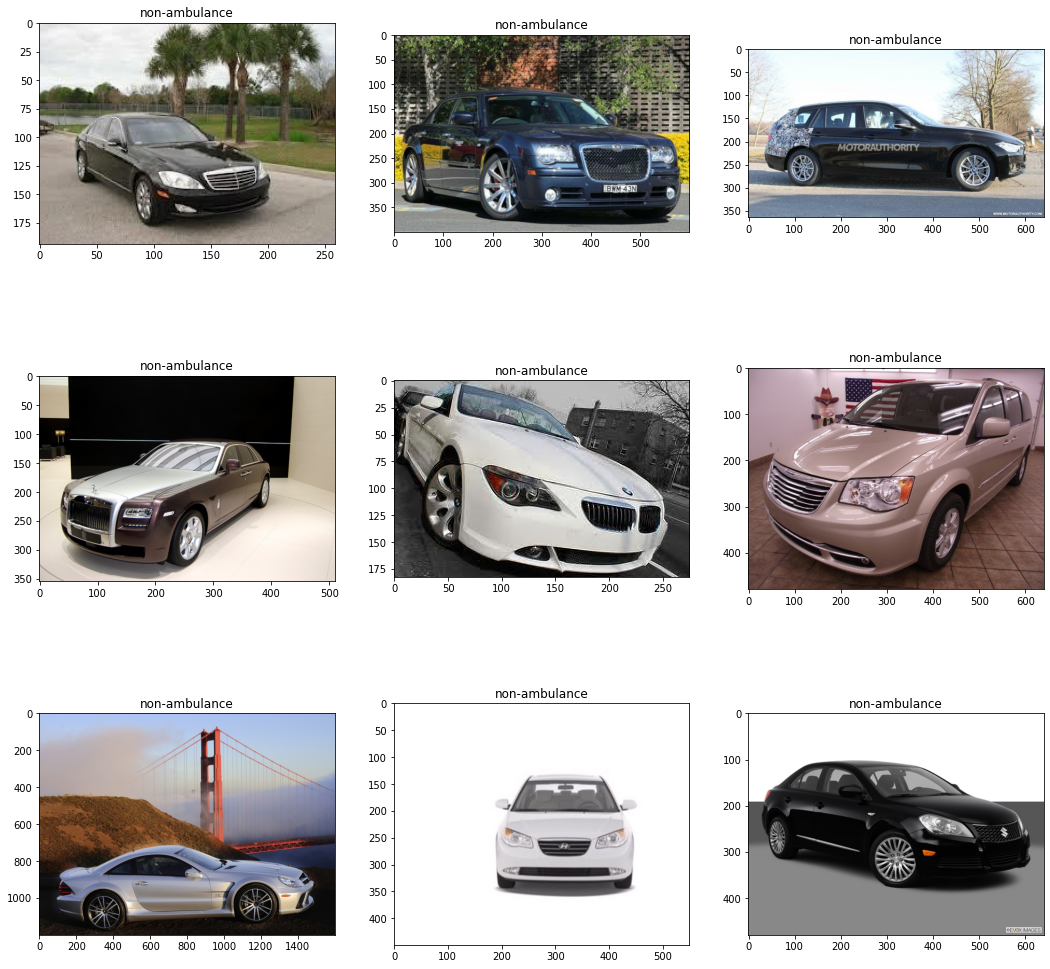

In [ ]:
# train set/non-ambulance image 확인

tmp_imgs = train_df['filename'][-9:] # image file name
plt.figure(figsize=(18,18))

for num, f_name in enumerate(tmp_imgs):
    img = PIL.Image.open(os.path.join('/content/train/non-ambulance', f_name))

    plt.subplot(3, 3, num + 1)
    plt.title('non-ambulance')
    plt.imshow(img)

ambulance image와 non-ambulance image의 크기가 다름.

### 전처리

In [ ]:
image_height = 224  # 이미지 높이
image_width = 224   # 이미지 넓이
batch_size = 64     # batch size
epochs  = 20  # trining 횟수

In [ ]:
# ImageDataGenerator 클래스를 통해 train_datagen, val_datagen 인스턴스를 생성.
# 픽셀 값을 0~1 범위로 변환

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# train_datagen 인스턴스를 통해 train dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 training_set 객체를 생성.
train_set = train_datagen.flow_from_directory('/content/train',
                                                 target_size=(image_width, image_height),
                                                 batch_size=batch_size,
                                                 class_mode='binary')


# val_datagen 인스턴스를 통해 test dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 test_set 객체를 생성.
test_set = val_datagen.flow_from_directory('/content/test',
                                            target_size=(image_width, image_height),
                                            batch_size=batch_size,
                                            class_mode='binary')

#val_datagen 인스턴스를 통해 val dataset 에서 한번에 batch_size 만큼 이미지를 만들어내는 val_set 객체를 생성.
val_set = val_datagen.flow_from_directory('/content/val',
                                           target_size=(image_width, image_height),
                                           batch_size=batch_size,
                                           shuffle=False,
                                           class_mode='binary')

Found 2400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [ ]:
# 각각의 data set 이 만들어 내는 이미지의 클래스 인덱스 확인
print(f'train set의 이미지 클래스: {train_set.class_indices}')
print(f'test set의 이미지 클래스: {test_set.class_indices}')
print(f'validation set의 이미지 클래스: {val_set.class_indices}')

train set의 이미지 클래스: {'ambulance': 0, 'non-ambulance': 1}
test set의 이미지 클래스: {'ambulance': 0, 'non-ambulance': 1}
validation set의 이미지 클래스: {'ambulance': 0, 'non-ambulance': 1}


In [ ]:
# next 함수를 사용하여 이미지와 라벨 값을 가져옴
# 현재는 배치 크기 80개가 한 묶음인 상태

train_image, train_label = train_set.next()
val_image, val_label = val_set.next()
test_image, test_label = test_set.next()

In [ ]:
len(train_image)

64

In [ ]:
len(train_set)

38

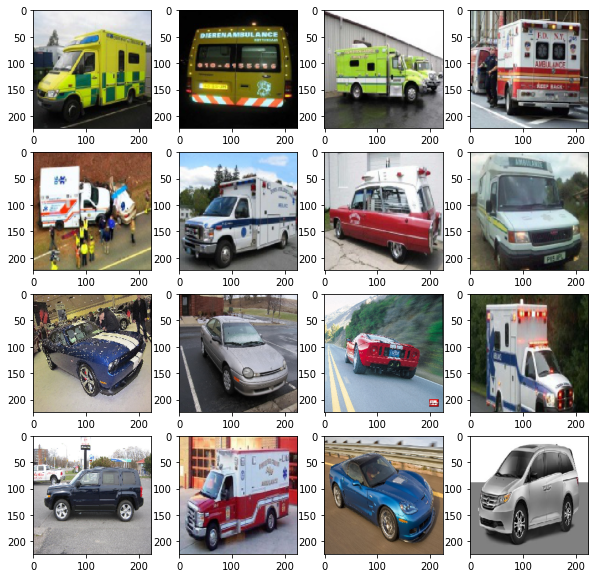

In [ ]:
# train_set 이미지 확인
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(train_image[i])
plt.show()

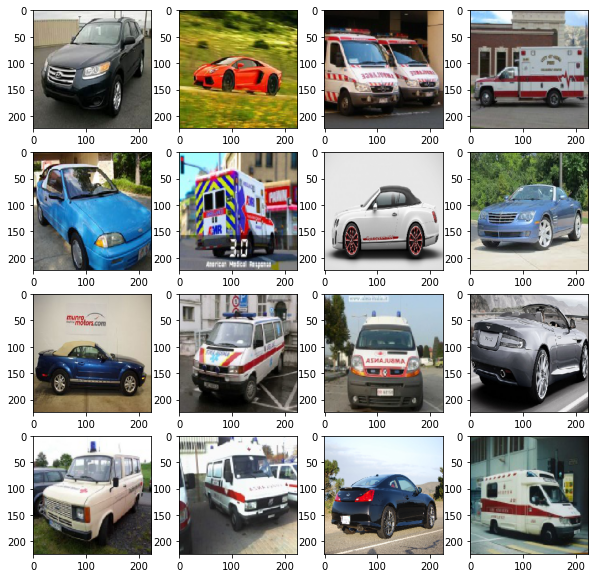

In [ ]:
# test_set 이미지 확인
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(test_image[i])
plt.show()

### 모델링

callback, optimizer 정의

In [ ]:
# optimizer 정의

opt = tf.keras.optimizers.Adam(learning_rate= 0.0001,beta_1=0.9, beta_2=0.999,epsilon=1e-07)

In [ ]:
# test set 이미지, 라벨 저장

label = []
image = []

for i in range(len(test_set)):
  temp_image,temp_label = test_set[i]
  for j in temp_image:
    image.append(np.array(j))
  for k in temp_label:
    label.append(np.array(k))

image= np.array(image)
label= np.array(label)

In [ ]:
# font 설정

font1 = {'family': 'DejaVu Sans',
         'weight': 'bold',
         'size': 20
         }

font2 = {'family': 'DejaVu Sans',
         'size': 16
         }   

#### Vanilla CNN

In [ ]:
# Vanilla CNN
vanilla_cnn_model = Sequential()

vanilla_cnn_model.add(Conv2D(32,(3,3),input_shape=(image_height,image_width,3),activation='relu'))
vanilla_cnn_model.add(Conv2D(32,(3,3),activation='relu'))
vanilla_cnn_model.add(MaxPooling2D(pool_size=(3,3)))
vanilla_cnn_model.add(Dropout(0.3))

vanilla_cnn_model.add(Conv2D(64,(3,3),activation='relu'))
vanilla_cnn_model.add(Conv2D(64,(3,3),activation='relu'))
vanilla_cnn_model.add(MaxPooling2D(pool_size=(3,3)))
vanilla_cnn_model.add(Dropout(0.3))

vanilla_cnn_model.add(Conv2D(128,(3,3),activation='relu'))
vanilla_cnn_model.add(Conv2D(128,(3,3),activation='relu'))
vanilla_cnn_model.add(MaxPooling2D(pool_size=(3,3)))
vanilla_cnn_model.add(Dropout(0.3))

vanilla_cnn_model.add(Flatten())
vanilla_cnn_model.add(Dense(units=128,activation='relu'))
vanilla_cnn_model.add(Dropout(0.2))
vanilla_cnn_model.add(Dense(units=1,activation='sigmoid'))

vanilla_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 69, 69, 64)        36928     
                                                        

In [ ]:
# 모델 학습시 가장 최신의 최고 모델을 저장하는 인스턴스를 정의
modelCheckpoint = ModelCheckpoint('/content/drive/MyDrive/AI 개발 프로젝트/vanilla_cnn_model.h5', save_best_only=True)

# 모델 학습시 정확도를 모니터링하여 조기에 학습을 종료시키는 인스턴스 정의
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

# callback 정의
callbacks= [monitor_val_acc, modelCheckpoint]

In [ ]:
vanilla_cnn_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

vanilla_cnn_history = vanilla_cnn_model.fit_generator(train_set,
                    steps_per_epoch=2400//batch_size,
                    epochs=epochs,
                    validation_data=val_set,
                    validation_steps=800//batch_size,
                    callbacks=callbacks,
                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
37/37 [==============================] - 25s 412ms/step - loss: 0.6885 - accuracy: 0.5445 - val_loss: 0.6870 - val_accuracy: 0.4818
Epoch 2/20
37/37 [==============================] - 14s 379ms/step - loss: 0.6622 - accuracy: 0.6087 - val_loss: 0.6318 - val_accuracy: 0.6341
Epoch 3/20
37/37 [==============================] - 14s 375ms/step - loss: 0.5126 - accuracy: 0.7479 - val_loss: 0.4124 - val_accuracy: 0.8190
Epoch 4/20
37/37 [==============================] - 14s 374ms/step - loss: 0.3998 - accuracy: 0.8082 - val_loss: 0.3346 - val_accuracy: 0.8867
Epoch 5/20
37/37 [==============================] - 14s 377ms/step - loss: 0.3078 - accuracy: 0.8686 - val_loss: 0.2584 - val_accuracy: 0.9154
Epoch 6/20
37/37 [==============================] - 14s 379ms/step - loss: 0.2573 - accuracy: 0.8908 - val_loss: 0.2265 - val_accuracy: 0.9323
Epoch 7/20
37/37 [==============================] - 14s 387ms/step - loss: 0.2105 - accuracy: 0.9126 - val_loss: 0.1875 - val_accuracy: 0.9388

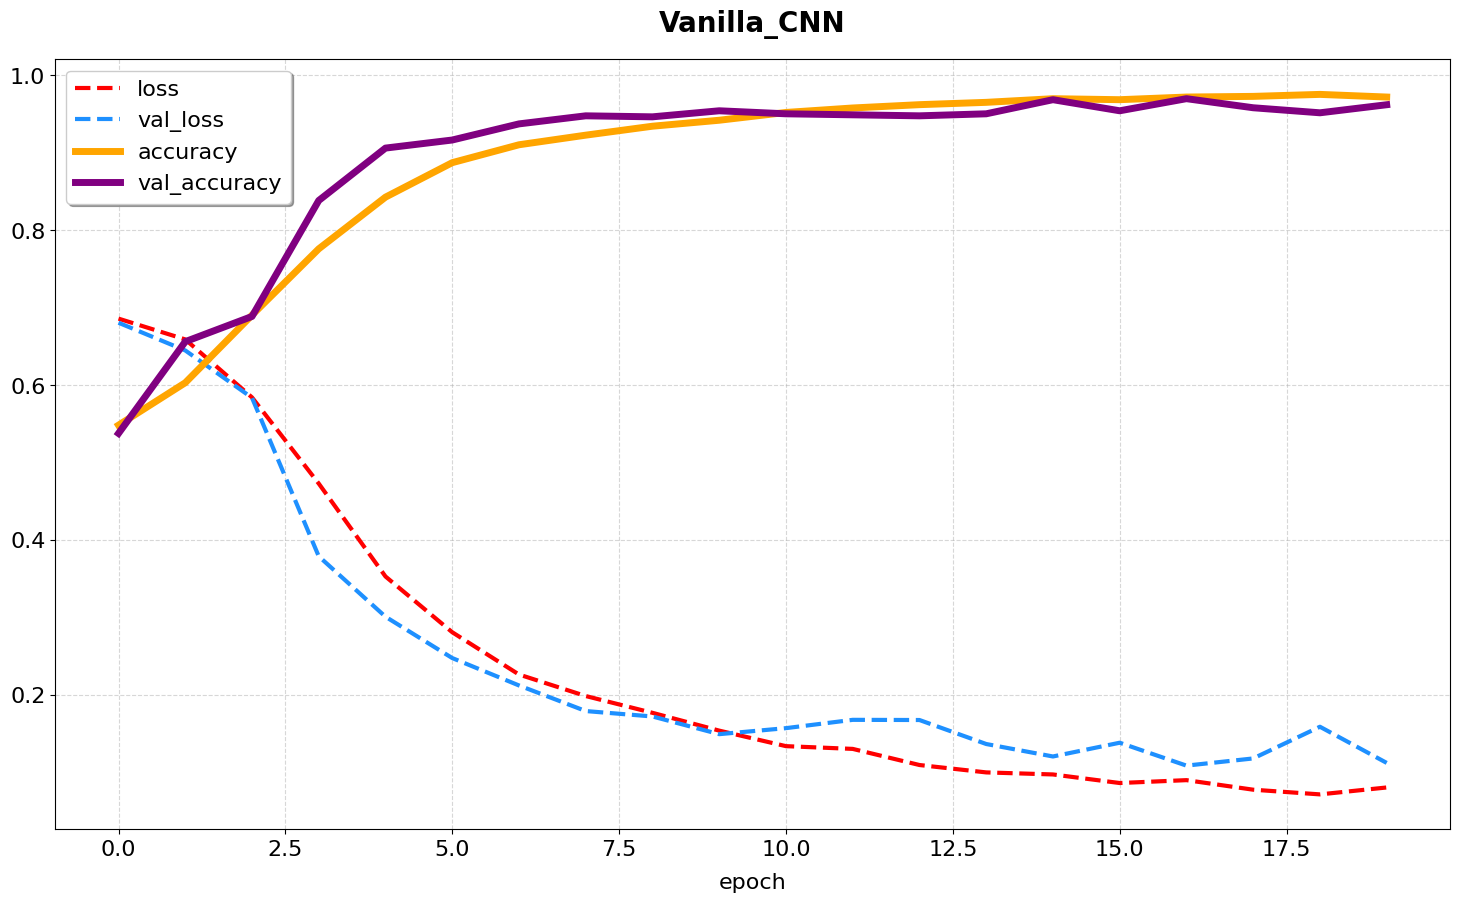

In [ ]:
plt.figure(figsize=(18,10))
plt.style.use('default')
plt.plot(vanilla_cnn_history.history['loss'], '--', c = 'red', label = 'loss', linewidth = 3)
plt.plot(vanilla_cnn_history.history['val_loss'], '--', c = 'dodgerblue', label = 'val_loss', linewidth = 3)
plt.plot(vanilla_cnn_history.history['accuracy'], c='orange',label = 'accuracy', linewidth = 5)
plt.plot(vanilla_cnn_history.history['val_accuracy'],c='purple',label = 'val_accuracy', linewidth = 5)


plt.legend(['loss', 'val_loss','accuracy','val_accuracy'],shadow = True, loc='best',fontsize = 16)
plt.title('Vanilla_CNN', fontdict=font1, pad = 20)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

In [ ]:
# vanilla_cnn_model 모델 평가
(test_loss, test_accuracy) = vanilla_cnn_model.evaluate(test_set, steps=800//batch_size, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy*100)

12/12 [==============================] - 4s 313ms/step - loss: 0.1513 - accuracy: 0.9557
Test loss: 0.15130741894245148
Test accuracy: 95.57291865348816


In [ ]:
# test 데이터에 대한 최종 예측
# 실제로 예측하고 그 출력은 입력 데이터에서 예측 한 목표 값

pred = vanilla_cnn_model.predict(image, steps=800//batch_size, verbose=1,callbacks=callbacks)
test_pred = np.rint(pred).flatten()

print(test_pred[:10],test_pred.shape,sep='\n')

12/12 [==============================] - 0s 31ms/step
[0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
(800,)


[[388  12]
 [ 12 388]]


[Text(0, 0.5, 'ambulance'), Text(0, 1.5, 'non_ambulance')]

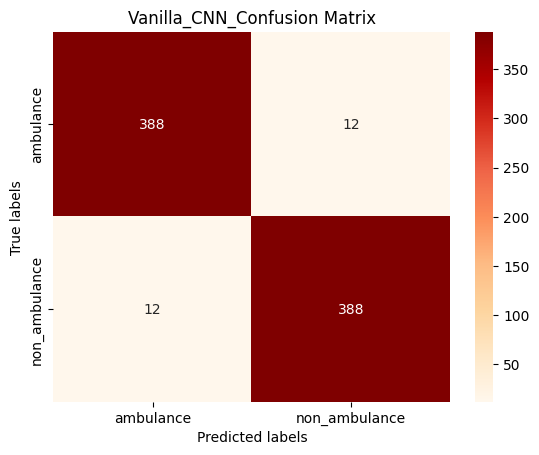

In [ ]:
matrix = confusion_matrix(test_pred, label)
print(matrix)

ax = plt.subplot()
sns.heatmap(matrix, annot=True, ax=ax, fmt='g', cmap='OrRd')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Vanilla_CNN_Confusion Matrix')
labels=['ambulance','non_ambulance']
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
TP = matrix[0][0]
FP = matrix[0][1]
FN = matrix[1][0]
TN = matrix[1][1]

accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = (2*precision*recall)/(precision+recall)
specificity = TN/(FP+TN)

print('정확도:', round(accuracy,6))
print('정밀도:', round(precision,6))
print('재현율:', round(recall,6))
print('특이도:', round(specificity,6))
print('f1-score:', round(f1_score,6))

정확도: 0.97
정밀도: 0.97
재현율: 0.97
특이도: 0.97
f1-score: 0.97


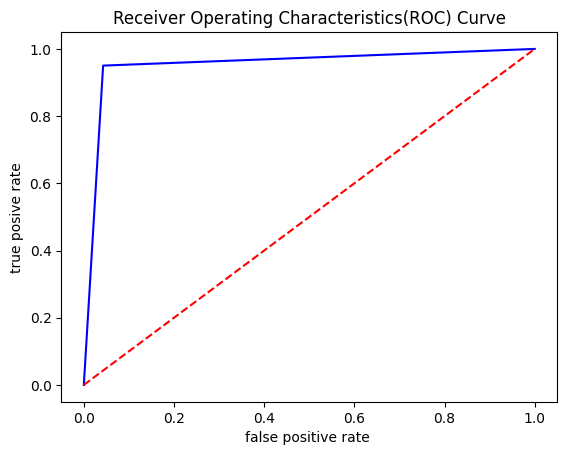

AUC:  0.9537755248732741


In [ ]:
# roc곡선 그리기

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test_pred,label)

# roc curve 함수 정의
def plot_roc_curve(specificity, recall): 
    plt.plot(specificity,recall, color='blue', label="ROC")
    plt.plot([0,1],[0,1], color='red', linestyle="--")
    plt.xlabel("false positive rate ")
    plt.ylabel("true posive rate")
    plt.title("Receiver Operating Characteristics(ROC) Curve")
    plt.legend
    plt.show()

specificity, recall, thresholds= roc_curve(test_pred, label)
plot_roc_curve(specificity, recall)
print('AUC: ',auc)

#### VGG16

In [ ]:
# VGG16

vgg16_model = Sequential()

vgg16_model.add(Conv2D(input_shape=(image_height,image_height, 3),filters=64,kernel_size=(3,3), padding='same', activation="relu"))
vgg16_model.add(Conv2D(filters=64,kernel_size=(3,3), padding='same', activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(Dropout(0.3))

vgg16_model.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation="relu"))
vgg16_model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same',activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(Dropout(0.3))

vgg16_model.add(Conv2D(filters=256, kernel_size=(3,3),padding='same', activation="relu"))
vgg16_model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same',activation="relu"))
vgg16_model.add(Conv2D(filters=256, kernel_size=(3,3),padding='same', activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(Dropout(0.3))

vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same',activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3),padding='same', activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3),padding='same', activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(Dropout(0.3))

vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same',activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same',activation="relu"))
vgg16_model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same',activation="relu"))
vgg16_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
vgg16_model.add(Dropout(0.3))

vgg16_model.add(Flatten())
vgg16_model.add(Dense(units=4096,activation="relu"))
vgg16_model.add(Dense(units=4096,activation="relu"))
vgg16_model.add(Dropout(0.2))
vgg16_model.add(Dense(units=1, activation="sigmoid"))

vgg16_model.summary()

In [ ]:
# 모델 학습시 가장 최신의 최고 모델을 저장하는 인스턴스를 정의
modelCheckpoint = ModelCheckpoint('/content/drive/MyDrive/AI 개발 프로젝트/vgg16_model.h5', save_best_only=True)

# 모델 학습시 정확도를 모니터링하여 조기에 학습을 종료시키는 인스턴스 정의
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

# callback 정의
callbacks= [monitor_val_acc, modelCheckpoint]

In [ ]:
vgg16_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

vgg16_history = vgg16_model.fit_generator(train_set,
                    steps_per_epoch=2400//batch_size,
                    epochs=epochs,
                    validation_data=val_set,
                    validation_steps=800//batch_size,
                    callbacks=callbacks,
                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
37/37 [==============================] - 32s 845ms/step - loss: 0.6520 - accuracy: 0.6169 - val_loss: 0.6238 - val_accuracy: 0.6680
Epoch 2/20
37/37 [==============================] - 26s 703ms/step - loss: 0.5700 - accuracy: 0.6961 - val_loss: 0.5305 - val_accuracy: 0.7500
Epoch 3/20
37/37 [==============================] - 26s 706ms/step - loss: 0.4889 - accuracy: 0.7821 - val_loss: 0.4162 - val_accuracy: 0.8542
Epoch 4/20
37/37 [==============================] - 26s 703ms/step - loss: 0.2956 - accuracy: 0.8754 - val_loss: 0.2536 - val_accuracy: 0.9180
Epoch 5/20
37/37 [==============================] - 26s 702ms/step - loss: 0.2247 - accuracy: 0.9140 - val_loss: 0.2266 - val_accuracy: 0.9297
Epoch 6/20
37/37 [==============================] - 20s 548ms/step - loss: 0.2040 - accuracy: 0.9229 - val_loss: 0.2705 - val_accuracy: 0.8815
Epoch 7/20
37/37 [==============================] - 26s 704ms/step - loss: 0.1317 - accuracy: 0.9469 - val_loss: 0.1325 - val_accuracy: 0.9544

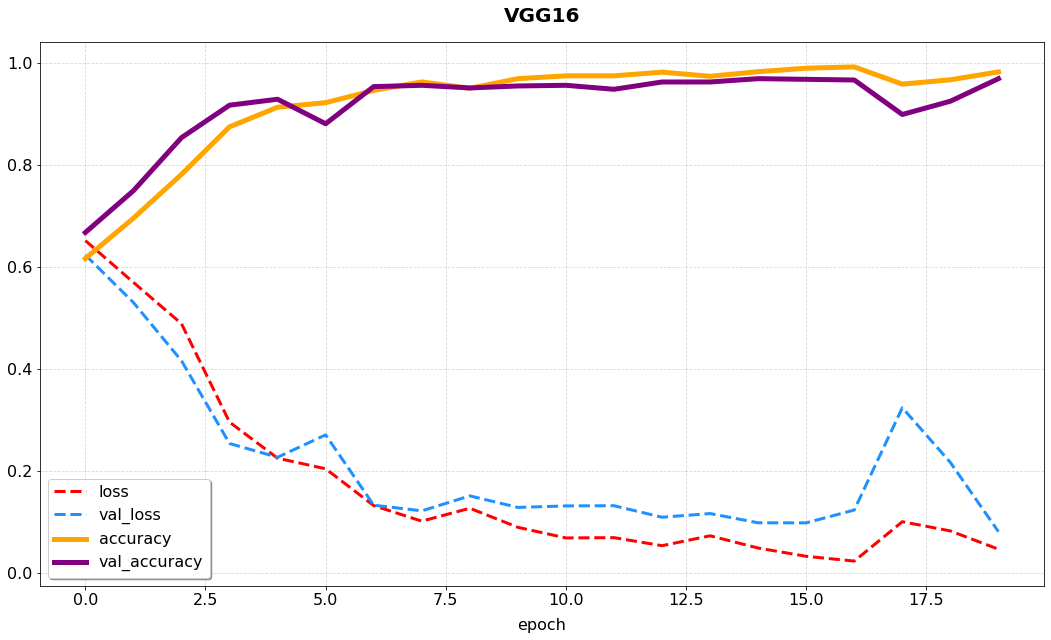

In [ ]:
plt.figure(figsize=(18,10))

plt.plot(vgg16_history.history['loss'], '--', c = 'red', label = 'loss', linewidth = 3)
plt.plot(vgg16_history.history['val_loss'], '--', c = 'dodgerblue', label = 'val_loss', linewidth = 3)
plt.plot(vgg16_history.history['accuracy'], c='orange',label = 'accuracy', linewidth = 5)
plt.plot(vgg16_history.history['val_accuracy'],c='purple',label = 'val_accuracy', linewidth = 5)


plt.legend(['loss', 'val_loss','accuracy','val_accuracy'],shadow = True, loc='best',fontsize = 16)
plt.title('VGG16', fontdict=font1, pad = 20)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

In [ ]:
# vgg16_model 모델 평가

(test_loss, test_accuracy) = vgg16_model.evaluate(test_set, steps=800//batch_size, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy*100)

12/12 [==============================] - 4s 305ms/step - loss: 0.1089 - accuracy: 0.9714
Test loss: 0.10893470048904419
Test accuracy: 97.13541865348816


In [ ]:
# test 데이터에 대한 최종 예측
# 실제로 예측하고 그 출력은 입력 데이터에서 예측 한 목표 값

pred = vgg16_model.predict(image, steps=800//batch_size, verbose=1,callbacks=[monitor_val_acc, modelCheckpoint])
test_pred = np.rint(pred).flatten()

print(test_pred[:10],test_pred.shape,sep='\n')

12/12 [==============================] - 2s 163ms/step
[1. 1. 1. 0. 0. 1. 1. 0. 1. 1.]
(800,)


[[389  11]
 [ 11 389]]


[Text(0, 0.5, 'ambulance'), Text(0, 1.5, 'non_ambulance')]

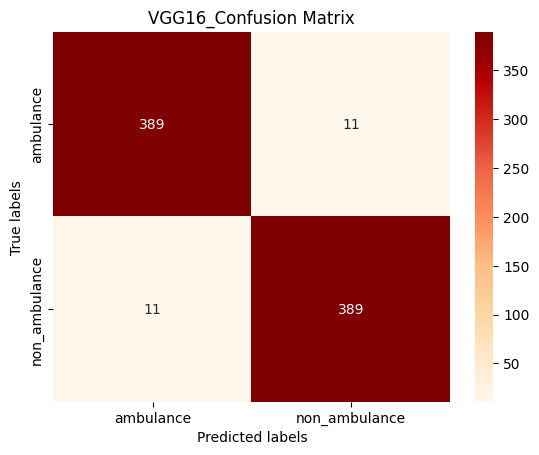

In [ ]:
matrix = confusion_matrix(test_pred, label)
print(matrix)

ax = plt.subplot()
sns.heatmap(matrix, annot=True, ax=ax, fmt='g', cmap='OrRd')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('VGG16_Confusion Matrix')
labels=['ambulance','non_ambulance']
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
TP = matrix[0][0]
FP = matrix[0][1]
FN = matrix[1][0]
TN = matrix[1][1]

accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = (2*precision*recall)/(precision+recall)
specificity = TN/(FP+TN)

print('정확도:', round(accuracy,6))
print('정밀도:', round(precision,6))
print('재현율:', round(recall,6))
print('특이도:', round(specificity,6))
print('f1-score:', round(f1_score,6))

정확도: 0.9725
정밀도: 0.9725
재현율: 0.9725
특이도: 0.9725
f1-score: 0.9725


AUC:  0.9725000000000001


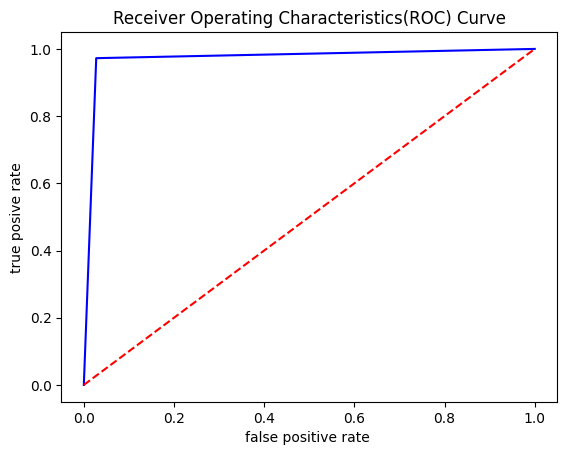

In [ ]:
# roc곡선 그리기

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test_pred,label)
print('AUC: ',auc)

# roc curve 함수 정의
def plot_roc_curve(specificity, recall): 
    plt.plot(specificity,recall, color='blue', label="ROC")
    plt.plot([0,1],[0,1], color='red', linestyle="--")
    plt.xlabel("false positive rate ")
    plt.ylabel("true posive rate")
    plt.title("Receiver Operating Characteristics(ROC) Curve")
    plt.legend
    plt.show()

specificity, recall, thresholds= roc_curve(test_pred, label)
plot_roc_curve(specificity, recall)

#### VGG 19

In [ ]:
# VGG19

vgg19_model = Sequential()

vgg19_model.add(Conv2D(input_shape=(image_height, image_width,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(Conv2D(filters=64, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg19_model.add(Conv2D(filters=128, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(Conv2D(filters=128, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg19_model.add(Conv2D(filters=256, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(Conv2D(filters=256, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(Conv2D(filters=256, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(Conv2D(filters=256, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg19_model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg19_model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(Conv2D(filters=512, kernel_size=(3,3),padding="same", activation="relu"))
vgg19_model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

vgg19_model.add(Flatten())
vgg19_model.add(Dense(units=4096,activation="relu"))
vgg19_model.add(Dense(units=4096,activation="relu"))
vgg19_model.add(Dense(units=1, activation="sigmoid"))

vgg19_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_58 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_59 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_60 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_61 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                 

In [ ]:
# 모델 학습시 가장 최신의 최고 모델을 저장하는 인스턴스를 정의
modelCheckpoint = ModelCheckpoint('/content/drive/MyDrive/AI 개발 프로젝트/vgg19_model.h5', save_best_only=True)

# 모델 학습시 정확도를 모니터링하여 조기에 학습을 종료시키는 인스턴스 정의
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

# callback 정의
callbacks= [monitor_val_acc, modelCheckpoint]

In [ ]:
vgg19_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

vgg19_history = vgg19_model.fit_generator(train_set,
                    steps_per_epoch=2400//batch_size,
                    epochs=epochs,
                    validation_data=val_set,
                    validation_steps=800//batch_size,
                    callbacks=[monitor_val_acc, modelCheckpoint],
                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
37/37 [==============================] - 29s 771ms/step - loss: 0.6925 - accuracy: 0.5218 - val_loss: 0.6807 - val_accuracy: 0.4792
Epoch 2/20
37/37 [==============================] - 29s 783ms/step - loss: 0.5789 - accuracy: 0.7239 - val_loss: 0.3334 - val_accuracy: 0.8919
Epoch 3/20
37/37 [==============================] - 29s 769ms/step - loss: 0.3156 - accuracy: 0.8763 - val_loss: 0.3024 - val_accuracy: 0.8906
Epoch 4/20
37/37 [==============================] - 29s 774ms/step - loss: 0.1830 - accuracy: 0.9319 - val_loss: 0.1380 - val_accuracy: 0.9531
Epoch 5/20
37/37 [==============================] - 23s 607ms/step - loss: 0.1563 - accuracy: 0.9508 - val_loss: 0.1891 - val_accuracy: 0.9401
Epoch 6/20
37/37 [==============================] - 29s 781ms/step - loss: 0.1439 - accuracy: 0.9529 - val_loss: 0.1189 - val_accuracy: 0.9674
Epoch 7/20
37/37 [==============================] - 23s 609ms/step - loss: 0.1103 - accuracy: 0.9653 - val_loss: 0.1321 - val_accuracy: 0.9609

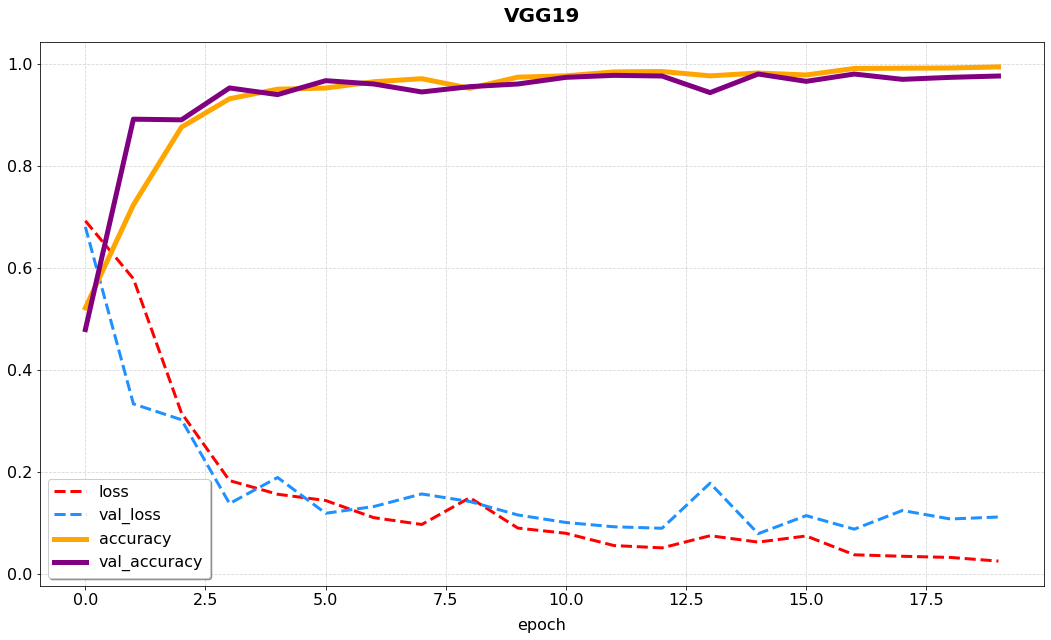

In [ ]:
plt.figure(figsize=(18,10))

plt.plot(vgg19_history.history['loss'], '--', c = 'red', label = 'loss', linewidth = 3)
plt.plot(vgg19_history.history['val_loss'], '--', c = 'dodgerblue', label = 'val_loss', linewidth = 3)
plt.plot(vgg19_history.history['accuracy'], c='orange',label = 'accuracy', linewidth = 5)
plt.plot(vgg19_history.history['val_accuracy'],c='purple',label = 'val_accuracy', linewidth = 5)


plt.legend(['loss', 'val_loss','accuracy','val_accuracy'],shadow = True, loc='best',fontsize = 16)
plt.title('VGG19', fontdict=font1, pad = 20)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

In [ ]:
# vgg19_model 모델 평가

(test_loss, test_accuracy) = vgg19_model.evaluate(test_set, steps=800//batch_size, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy*100)

12/12 [==============================] - 4s 288ms/step - loss: 0.1243 - accuracy: 0.9740
Test loss: 0.12426147609949112
Test accuracy: 97.39583134651184


In [ ]:
# test 데이터에 대한 최종 예측
# 실제로 예측하고 그 출력은 입력 데이터에서 예측 한 목표 값

pred = vgg19_model.predict(image, steps=800//batch_size, verbose=1,callbacks=[monitor_val_acc, modelCheckpoint])
test_pred = np.rint(pred).flatten()

print(test_pred[:10],test_pred.shape,sep='\n')

12/12 [==============================] - 2s 193ms/step
[0. 1. 1. 0. 0. 1. 1. 0. 1. 1.]
(800,)


[[391  11]
 [  9 389]]


[Text(0, 0.5, 'ambulance'), Text(0, 1.5, 'non_ambulance')]

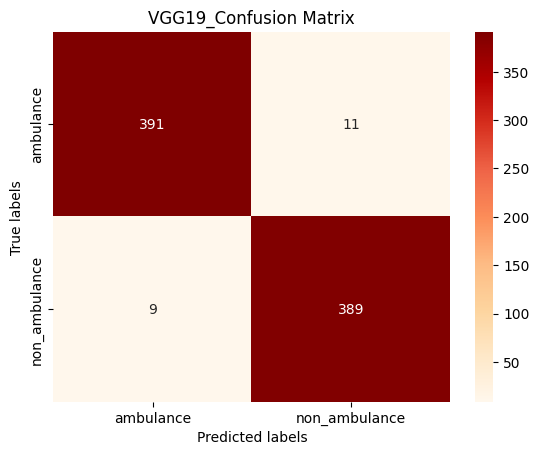

In [ ]:
matrix = confusion_matrix(test_pred, label)
print(matrix)

ax = plt.subplot()
sns.heatmap(matrix, annot=True, ax=ax, fmt='g', cmap='OrRd')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('VGG19_Confusion Matrix')
labels=['ambulance','non_ambulance']
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
TP = matrix[0][0]
FP = matrix[0][1]
FN = matrix[1][0]
TN = matrix[1][1]

accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = (2*precision*recall)/(precision+recall)
specificity = TN/(FP+TN)

print('정확도:', round(accuracy,6))
print('정밀도:', round(precision,6))
print('재현율:', round(recall,6))
print('특이도:', round(specificity,6))
print('f1-score:', round(f1_score,6))

정확도: 0.975
정밀도: 0.972637
재현율: 0.9775
특이도: 0.9725
f1-score: 0.975062


AUC:  0.9750118752968824


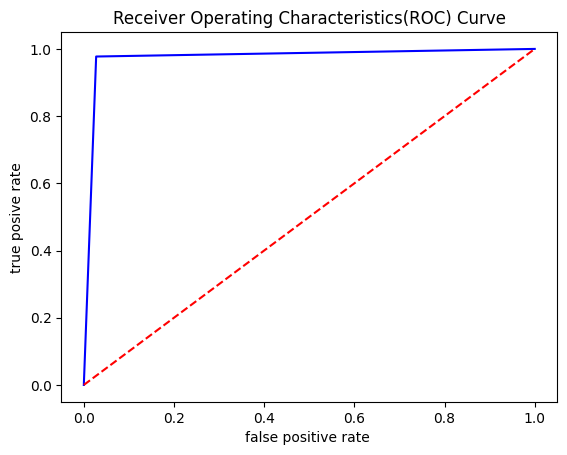

In [ ]:
# roc곡선 그리기

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test_pred,label)
print('AUC: ',auc)

# roc curve 함수 정의
def plot_roc_curve(specificity, recall): 
    plt.plot(specificity,recall, color='blue', label="ROC")
    plt.plot([0,1],[0,1], color='red', linestyle="--")
    plt.xlabel("false positive rate ")
    plt.ylabel("true posive rate")
    plt.title("Receiver Operating Characteristics(ROC) Curve")
    plt.legend
    plt.show()

specificity, recall, thresholds= roc_curve(test_pred, label)
plot_roc_curve(specificity, recall)

#### ResNet50

In [ ]:
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))

In [ ]:
x1 = resnet50.output
x1 = Flatten()(x1)
x1 = Dense(128,activation='relu')(x1)
x1 = Dropout(0.3)(x1)
x1 = Dense(1,activation='sigmoid')(x1)

In [ ]:
resnet50_model = Model(inputs=resnet50.input, outputs=x1)
# resnet50_model.summary()

In [ ]:
# 모델 학습시 가장 최신의 최고 모델을 저장하는 인스턴스를 정의
modelCheckpoint = ModelCheckpoint('/content/drive/MyDrive/AI 개발 프로젝트/resnet50_model.h5', save_best_only=True)

# 모델 학습시 정확도를 모니터링하여 조기에 학습을 종료시키는 인스턴스 정의
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

# callback 정의
callbacks= [monitor_val_acc, modelCheckpoint]

In [ ]:
resnet50_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

resnet50_history = resnet50_model.fit_generator(train_set,
                    steps_per_epoch=2400//batch_size,
                    epochs=epochs,
                    validation_data=val_set,
                    validation_steps=800//batch_size,
                    callbacks= callbacks
                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
37/37 [==============================] - 28s 626ms/step - loss: 0.3213 - accuracy: 0.9242 - val_loss: 0.6630 - val_accuracy: 0.5482
Epoch 2/20
37/37 [==============================] - 17s 447ms/step - loss: 0.0041 - accuracy: 0.9979 - val_loss: 0.9723 - val_accuracy: 0.5221
Epoch 3/20
37/37 [==============================] - 16s 439ms/step - loss: 6.3455e-04 - accuracy: 1.0000 - val_loss: 0.7636 - val_accuracy: 0.5299
Epoch 4/20
37/37 [==============================] - 16s 439ms/step - loss: 4.0762e-04 - accuracy: 1.0000 - val_loss: 1.1731 - val_accuracy: 0.5234
Epoch 5/20
37/37 [==============================] - 17s 446ms/step - loss: 4.3013e-05 - accuracy: 1.0000 - val_loss: 1.0424 - val_accuracy: 0.5273
Epoch 6/20
37/37 [==============================] - 16s 437ms/step - loss: 7.6027e-05 - accuracy: 1.0000 - val_loss: 0.7751 - val_accuracy: 0.5625
Epoch 7/20
37/37 [==============================] - 17s 449ms/step - loss: 1.0542e-04 - accuracy: 1.0000 - val_loss: 0.9165 - 

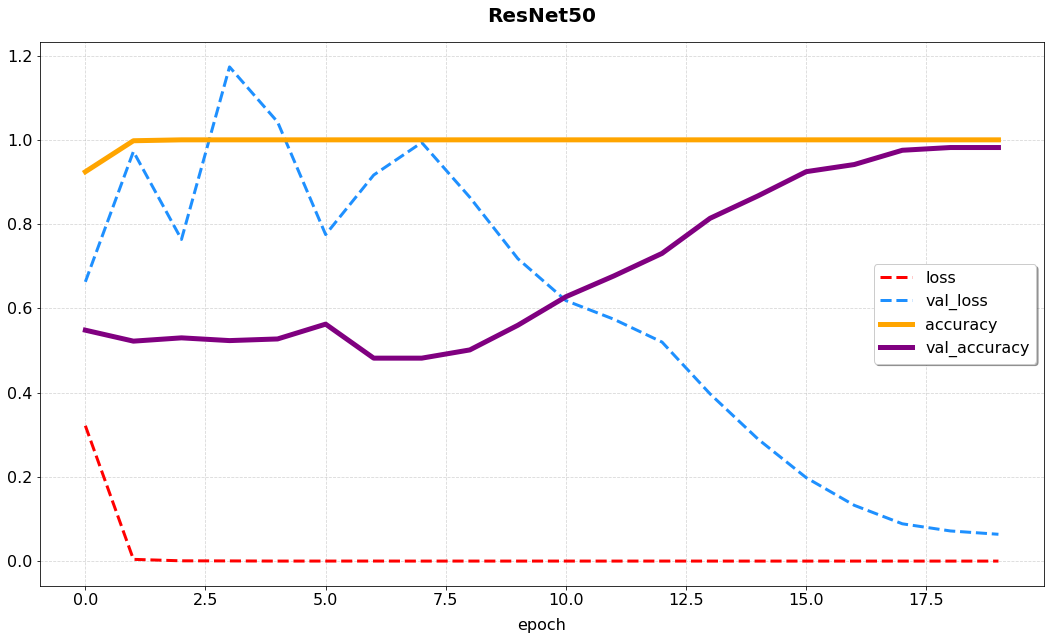

In [ ]:
plt.figure(figsize=(18,10))

plt.plot(resnet50_history.history['loss'], '--', c = 'red', label = 'loss', linewidth = 3)
plt.plot(resnet50_history.history['val_loss'], '--', c = 'dodgerblue', label = 'val_loss', linewidth = 3)
plt.plot(resnet50_history.history['accuracy'], c='orange',label = 'accuracy', linewidth = 5)
plt.plot(resnet50_history.history['val_accuracy'],c='purple',label = 'val_accuracy', linewidth = 5)


plt.legend(['loss', 'val_loss','accuracy','val_accuracy'],shadow = True, loc='best',fontsize = 16)
plt.title('ResNet50', fontdict=font1, pad = 20)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

In [ ]:
# resnet50_model 모델 평가
(test_loss, test_accuracy) = resnet50_model.evaluate(test_set, steps=800//batch_size, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy*100)

12/12 [==============================] - 4s 305ms/step - loss: 0.0523 - accuracy: 0.9883
Test loss: 0.052310168743133545
Test accuracy: 98.828125


In [ ]:
pred = resnet50_model.predict(image, steps=800//batch_size, verbose=1)
test_pred = np.rint(pred).flatten()

print(test_pred[:10],test_pred.shape,sep='\n')

12/12 [==============================] - 3s 130ms/step
[0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
(800,)


[[395   4]
 [  5 396]]


[Text(0, 0.5, 'ambulance'), Text(0, 1.5, 'non_ambulance')]

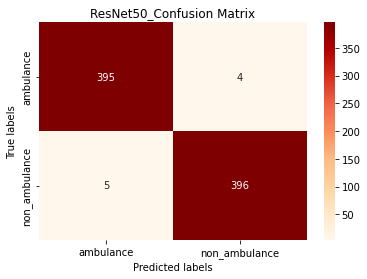

In [ ]:
matrix = confusion_matrix(test_pred, label)
print(matrix)

ax = plt.subplot()
sns.heatmap(matrix, annot=True, ax=ax, fmt='g', cmap='OrRd')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('ResNet50_Confusion Matrix')
labels=['ambulance','non_ambulance']
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
TP = matrix[0][0]
FP = matrix[0][1]
FN = matrix[1][0]
TN = matrix[1][1]

accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = (2*precision*recall)/(precision+recall)
specificity = TN/(FP+TN)

print('정확도:', round(accuracy,6))
print('정밀도:', round(precision,6))
print('재현율:', round(recall,6))
print('특이도:', round(specificity,6))
print('f1-score:', round(f1_score,6))

정확도: 0.98875
정밀도: 0.989975
재현율: 0.9875
특이도: 0.99
f1-score: 0.988736


AUC:  0.9887530547065919


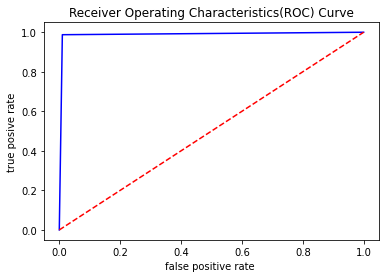

In [ ]:
# roc곡선 그리기

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test_pred,label)
print('AUC: ',auc)

# roc curve 함수 정의
def plot_roc_curve(specificity, recall): 
    plt.plot(specificity,recall, color='blue', label="ROC")
    plt.plot([0,1],[0,1], color='red', linestyle="--")
    plt.xlabel("false positive rate ")
    plt.ylabel("true posive rate")
    plt.title("Receiver Operating Characteristics(ROC) Curve")
    plt.legend
    plt.show()

specificity, recall, thresholds= roc_curve(test_pred, label)
plot_roc_curve(specificity, recall)

#### ResNet152v2

In [ ]:
resnet152 = ResNet152V2(include_top=False, weights='imagenet', input_shape=(224,224,3))

234561536/234545216 [==============================] - 4s 0us/step


In [ ]:
x2 = resnet152.output
x2 = Flatten()(x2)
x2 = Dense(128,activation='relu')(x2)
x2 = Dropout(0.3)(x2)
x2 = Dense(1,activation='sigmoid')(x2)

In [ ]:
resnet152v2_model = Model(inputs=resnet152.input, outputs=x2)
# resnet152v2_model.summary()

In [ ]:
# 모델 학습시 가장 최신의 최고 모델을 저장하는 인스턴스를 정의
modelCheckpoint = ModelCheckpoint('/content/drive/MyDrive/AI 개발 프로젝트/resnet152v2_model.h5', save_best_only=True)

# 모델 학습시 정확도를 모니터링하여 조기에 학습을 종료시키는 인스턴스 정의
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

# callback 정의
callbacks= [modelCheckpoint,monitor_val_acc]

In [ ]:
resnet152v2_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
resnet152v2_history = resnet152v2_model.fit_generator(train_set,
                    steps_per_epoch=2400//batch_size,
                    epochs=epochs,
                    validation_data=val_set,
                    validation_steps=800//batch_size,
                    callbacks=callbacks
                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
37/37 [==============================] - 49s 922ms/step - loss: 0.2021 - accuracy: 0.9503 - val_loss: 44.7846 - val_accuracy: 0.3724
Epoch 2/20
37/37 [==============================] - 32s 849ms/step - loss: 0.0193 - accuracy: 0.9949 - val_loss: 25.2294 - val_accuracy: 0.6055
Epoch 3/20
37/37 [==============================] - 32s 857ms/step - loss: 0.0072 - accuracy: 0.9992 - val_loss: 6.0954 - val_accuracy: 0.8099
Epoch 4/20
37/37 [==============================] - 32s 849ms/step - loss: 0.0105 - accuracy: 0.9974 - val_loss: 0.3616 - val_accuracy: 0.9818
Epoch 5/20
37/37 [==============================] - 32s 849ms/step - loss: 0.0055 - accuracy: 0.9979 - val_loss: 0.2035 - val_accuracy: 0.9935
Epoch 6/20
37/37 [==============================] - 31s 848ms/step - loss: 2.2596e-04 - accuracy: 1.0000 - val_loss: 0.1717 - val_accuracy: 0.9909
Epoch 7/20
37/37 [==============================] - 31s 849ms/step - loss: 0.0032 - accuracy: 0.9991 - val_loss: 0.1593 - val_accuracy: 

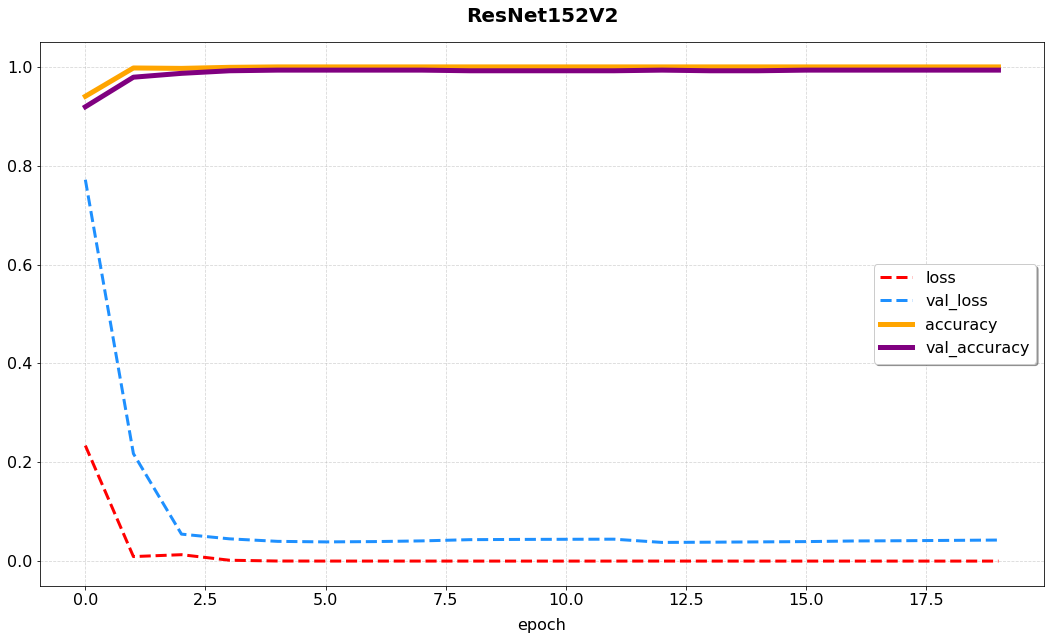

In [ ]:
plt.figure(figsize=(18,10))

plt.plot(resnet152v2_history.history['loss'], '--', c = 'red', label = 'loss', linewidth = 3)
plt.plot(resnet152v2_history.history['val_loss'], '--', c = 'dodgerblue', label = 'val_loss', linewidth = 3)
plt.plot(resnet152v2_history.history['accuracy'], c='orange',label = 'accuracy', linewidth = 5)
plt.plot(resnet152v2_history.history['val_accuracy'],c='purple',label = 'val_accuracy', linewidth = 5)


plt.legend(['loss', 'val_loss','accuracy','val_accuracy'],shadow = True, loc='best',fontsize = 16)
plt.title('ResNet152V2', fontdict=font1, pad = 20)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

In [ ]:
# resnet_model 모델 평가
(test_loss, test_accuracy) = resnet152v2_model.evaluate(test_set, steps=800//batch_size, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy*100)

12/12 [==============================] - 4s 283ms/step - loss: 0.0854 - accuracy: 0.9948
Test loss: 0.08537676930427551
Test accuracy: 99.47916865348816


In [ ]:
pred = resnet152v2_model.predict(image, steps=800//batch_size, verbose=1)
test_pred = np.rint(pred).flatten()

print(test_pred[:10],test_pred.shape,sep='\n')

12/12 [==============================] - 6s 278ms/step
[1. 0. 0. 1. 1. 1. 0. 1. 0. 1.]
(800,)


[[399   3]
 [  1 397]]


[Text(0, 0.5, 'ambulance'), Text(0, 1.5, 'non_ambulance')]

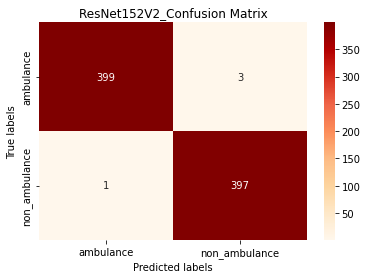

In [ ]:
matrix = confusion_matrix(test_pred, label)
print(matrix)

ax = plt.subplot()
sns.heatmap(matrix, annot=True, ax=ax, fmt='g', cmap='OrRd')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('ResNet152V2_Confusion Matrix')
labels=['ambulance','non_ambulance']
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
TP = matrix[0][0]
FP = matrix[0][1]
FN = matrix[1][0]
TN = matrix[1][1]

accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = (2*precision*recall)/(precision+recall)
specificity = TN/(FP+TN)

print('정확도:', round(accuracy,6))
print('정밀도:', round(precision,6))
print('재현율:', round(recall,6))
print('특이도:', round(specificity,6))
print('f1-score:', round(f1_score,6))

정확도: 0.995
정밀도: 0.992537
재현율: 0.9975
특이도: 0.9925
f1-score: 0.995012


AUC:  0.9950123753093827


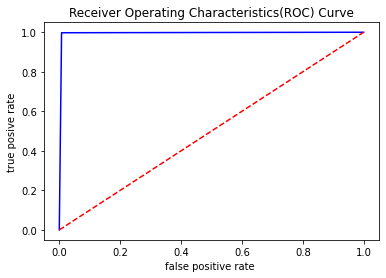

In [ ]:
# roc곡선 그리기

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test_pred,label)
print('AUC: ',auc)

# roc curve 함수 정의
def plot_roc_curve(specificity, recall): 
    plt.plot(specificity,recall, color='blue', label="ROC")
    plt.plot([0,1],[0,1], color='red', linestyle="--")
    plt.xlabel("false positive rate ")
    plt.ylabel("true posive rate")
    plt.title("Receiver Operating Characteristics(ROC) Curve")
    plt.legend
    plt.show()

specificity, recall, thresholds= roc_curve(test_pred, label)
plot_roc_curve(specificity, recall)

IndexError: ignored

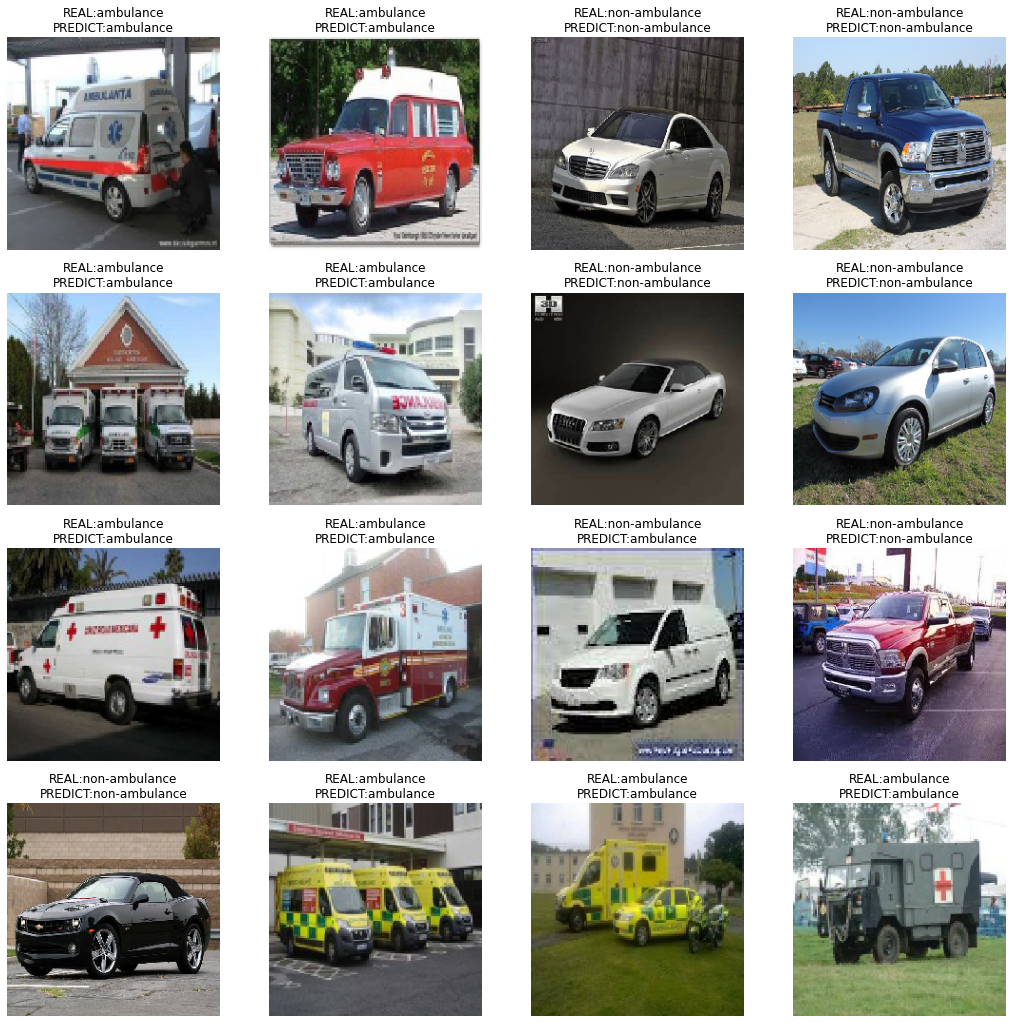

In [ ]:
f,ax = plt.subplots(4,4,figsize=(18,18))

for i in range(len(image)):
    real_class = 'ambulance' if label[i] == 0 else 'non-ambulance'   # pred_generator 가 만들어 낸 이미지의 label name 을 가져옴
    pred_class = 'ambulance' if test_pred[i] == 0 else 'non-ambulance' # pred_generator 가 만들어 낸 이미지를 모델을 통해 예측한 결과 값의 label name
      
    ax[i//4,i%4].imshow(image[i])                      # pred_generator 가 만들어 낸 이미지를 보여줌
    ax[i//4,i%4].axis('off')
    
    ax[i//4,i%4].set_title('REAL:' + real_class + '\nPREDICT:' + pred_class)  # title 에 실제값과 모델에 의해 예측된 예측값을 함께 보여준다.

f.suptitle('Predict Result')

plt.show()

#### googlenet

In [ ]:
import os

# os.environ["KERAS_BACKEND"] = 'plaidml.keras.backend'

import keras
import keras.backend as K
from tensorflow.keras.layers import Add
from keras.models import Model,load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, \
    AveragePooling2D, Flatten, Concatenate,Lambda

import cv2
import numpy as np
from keras.datasets import cifar10
from keras.utils import np_utils

import math
from tensorflow.keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler
import matplotlib

In [ ]:
def Scaling_Residual(Inception, scale):
    x = Lambda(lambda Inception, scale: Inception * scale, arguments={'scale': scale})(Inception)
    x = Activation(activation='relu')(x)
    
    return x

def Inception_ResNet_A(input_tensor, scale=0.1, version=None, name=None):   
    if version == 'Inception-ResNet-v1':
        branch_1 = conv2d_bn(input_tensor, 32, (1, 1))
    
        branch_2 = conv2d_bn(input_tensor, 32, (1, 1))
        branch_2 = conv2d_bn(branch_2, 32, (3, 3))
        
        branch_3 = conv2d_bn(input_tensor, 32, (1, 1))
        branch_3 = conv2d_bn(branch_3, 32, (3, 3))
        branch_3 = conv2d_bn(branch_3, 32, (3, 3))
        
        branches = Concatenate()([branch_1, branch_2, branch_3])
        Inception = conv2d_bn(branches, 256, (1, 1), activation=None)
    
    elif version == 'Inception-ResNet-v2':
        branch_1 = conv2d_bn(input_tensor, 32, (1, 1))
    
        branch_2 = conv2d_bn(input_tensor, 32, (1, 1))
        branch_2 = conv2d_bn(branch_2, 32, (3, 3))
        
        branch_3 = conv2d_bn(input_tensor, 32, (1, 1))
        branch_3 = conv2d_bn(branch_3, 48, (3, 3))
        branch_3 = conv2d_bn(branch_3, 64, (3, 3))
        
        branches = Concatenate()([branch_1, branch_2, branch_3])
        Inception = conv2d_bn(branches, 384, (1, 1), activation=None)
    
    else:
        return None # Kill ^^
    
    scaled_activation = Scaling_Residual(Inception, scale=scale)
    
    residual_connection = Add(name=name)([input_tensor, scaled_activation]) if name else Add()([input_tensor, scaled_activation])
    
    return residual_connection

def Inception_ResNet_B(input_tensor, scale=0.1, version=None, name=None):
    if version == 'Inception-ResNet-v1':
        branch_1 = conv2d_bn(input_tensor, 128, (1, 1))
        
        branch_2 = conv2d_bn(input_tensor, 128, (1, 1))
        branch_2 = conv2d_bn(branch_2, 128, (1, 7))
        branch_2 = conv2d_bn(branch_2, 128, (7, 1))
        
        branches = Concatenate()([branch_1, branch_2])
        Inception = conv2d_bn(branches, 896, (1, 1), activation=None)
    
    elif version == 'Inception-ResNet-v2':
        branch_1 = conv2d_bn(input_tensor, 192, (1, 1))
        
        branch_2 = conv2d_bn(input_tensor, 128, (1, 1))
        branch_2 = conv2d_bn(branch_2, 160, (1, 7))
        branch_2 = conv2d_bn(branch_2, 192, (7, 1))
        
        branches = Concatenate()([branch_1, branch_2])
        Inception = conv2d_bn(branches, 1152, (1, 1), activation=None) # Fig.17 is wrong
    
    else:
        return None # Kill ^^
    
    scaled_activation = Scaling_Residual(Inception, scale=scale)
    
    residual_connection = Add(name=name)([input_tensor, scaled_activation]) if name else Add()([input_tensor, scaled_activation])
    
    return residual_connection

def Inception_ResNet_C(input_tensor, scale=0.1, version=None, name=None):    
    if version == 'Inception-ResNet-v1':
        branch_1 = conv2d_bn(input_tensor, 192, (1, 1))
        
        branch_2 = conv2d_bn(input_tensor, 192, (1, 1))
        branch_2 = conv2d_bn(branch_2, 192, (1, 3))
        branch_2 = conv2d_bn(branch_2, 192, (3, 1))
        
        branches = Concatenate()([branch_1, branch_2])
        Inception = conv2d_bn(branches, 1792, (1, 1), activation=None)
    
    elif version == 'Inception-ResNet-v2':
        branch_1 = conv2d_bn(input_tensor, 192, (1, 1))
        
        branch_2 = conv2d_bn(input_tensor, 192, (1, 1))
        branch_2 = conv2d_bn(branch_2, 224, (1, 3))
        branch_2 = conv2d_bn(branch_2, 256, (3, 1))
        
        branches = Concatenate()([branch_1, branch_2])
        Inception = conv2d_bn(branches, 2144, (1, 1), activation=None) # Fig.19 is wrong
    
    else:
        return None # Kill ^^
    
    scaled_activation = Scaling_Residual(Inception, scale=scale)
    
    residual_connection = Add(name=name)([input_tensor, scaled_activation]) if name else Add()([input_tensor, scaled_activation])
    
    return residual_connection

def Inception_ResNet(model_input, version='Inception-ResNet-v2', classes=1):    
    x = Stem(model_input, version=version, name='Stem')
    # Inception-ResNet-v1 : (299, 299, 3) -> (35, 35, 256)
    # Inception-ResNet-v2 : (299, 299, 3) -> (35, 35, 384)
    
    for i in range(5):
        x = Inception_ResNet_A(x, scale=0.17, version=version, name='Inception-ResNet-A-'+str(i+1))
        # Inception-ResNet-v1 : (35, 35, 256)
        # Inception-ResNet-v2 : (35, 35, 384)
        
    x = Reduction_A(x, version=version, name='Reduction-A')
    # Inception-ResNet-v1 : (35, 35, 256) -> (17, 17, 896)
    # Inception-ResNet-v2 : (35, 35, 384) -> (17, 17, 1152)
    
    for i in range(10):
        x = Inception_ResNet_B(x, scale=0.1, version=version, name='Inception-ResNet-B-'+str(i+1))
        # Inception-ResNet-v1 : (17, 17, 896)
        # Inception-ResNet-v2 : (17, 17, 1152)

    x = Reduction_B(x, version=version, name='Reduction-B')
    # Inception-ResNet-v1 : (17, 17, 896) -> (8, 8, 1792)
    # Inception-ResNet-v2 : (17, 17, 1152) -> (8, 8, 2144)
    
    for i in range(5):
        x = Inception_ResNet_C(x, scale=0.2, version=version, name='Inception-ResNet-C-'+str(i+1))
        # Inception-ResNet-v1 : (8, 8, 1792)
        # Inception-ResNet-v2 : (8, 8, 2144)
    
    x = GlobalAveragePooling2D()(x)
    # Inception-ResNet-v1 : (1792)
    # Inception-ResNet-v2 : (2144)
    
    x = Dropout(0.8)(x)
    
    model_output = Dense(classes, activation='sigmoid', name='output')(x)

    model = Model(model_input, model_output, name=version)
    model.summary()
    
    return model
    
def conv2d_bn(x, filters, kernel_size, padding='same', strides=1, activation='relu'):
    x = Conv2D(filters, (kernel_size[0], kernel_size[1]), padding=padding, strides=strides)(x)    
    x = BatchNormalization()(x)
    
    if activation:
        x = Activation(activation)(x)
    
    return x

In [ ]:
def Stem(input_tensor, version=None, name=None):
    if version == 'Inception-v4' or version == 'Inception-ResNet-v2':
        x = conv2d_bn(input_tensor, 32, (3, 3), padding='valid', strides=2) # 299x299x3 -> 149x149x32
        x = conv2d_bn(x, 32, (3, 3), padding='valid') # 149x149x32 -> 147x147x32
        x = conv2d_bn(x, 64, (3, 3)) # 147x147x32 -> 147x147x64
        
        branch_1 = MaxPooling2D((3, 3), padding='valid', strides=2)(x)
        branch_2 = conv2d_bn(x, 96, (3, 3), padding='valid', strides=2)
        x = Concatenate()([branch_1, branch_2]) # 73x73x160
        
        branch_1 = conv2d_bn(x, 64, (1, 1))
        branch_1 = conv2d_bn(branch_1, 96, (3, 3), padding='valid')
        branch_2 = conv2d_bn(x, 64, (1, 1))
        branch_2 = conv2d_bn(branch_2, 64, (7, 1))
        branch_2 = conv2d_bn(branch_2, 64, (1, 7))
        branch_2 = conv2d_bn(branch_2, 96, (3, 3), padding='valid')
        x = Concatenate()([branch_1, branch_2]) # 71x71x192
        
        branch_1 = conv2d_bn(x, 192, (3, 3), padding='valid', strides=2) # Fig.4 is wrong
        branch_2 = MaxPooling2D((3, 3), padding='valid', strides=2)(x)
        x = Concatenate(name=name)([branch_1, branch_2]) if name else Concatenate()([branch_1, branch_2]) # 35x35x384
        
    elif version == 'Inception-ResNet-v1':
        x = conv2d_bn(input_tensor, 32, (3, 3), padding='valid', strides=2) # 299x299x3 -> 149x149x32
        x = conv2d_bn(x, 32, (3, 3), padding='valid') # 149x149x32 -> 147x147x32
        x = conv2d_bn(x, 64, (3, 3)) # 147x147x32 -> 147x147x64
        
        x = MaxPooling2D((3, 3), strides=2, padding='valid')(x) # 147x147x64 -> 73x73x64
        
        x = conv2d_bn(x, 80, (1, 1)) # 73x73x64 -> 73x73x80
        x = conv2d_bn(x, 192, (3, 3), padding='valid') # 73x73x80 -> 71x71x192U
        x = conv2d_bn(x, 256, (3, 3), padding='valid', strides=2, name=name) # 71x71x192 -> 35x35x256
        
    else:
        return None # Kill ^^
    
    return x

reduction_table = {'Inception-v4' : [192, 224, 256, 384],
                   'Inception-ResNet-v1' : [192, 192, 256, 384],
                   'Inception-ResNet-v2' : [256, 256, 384, 384]}

def Reduction_A(input_tensor, version=None, name=None):
    k, l, m, n = reduction_table[version]

    branch_1 = MaxPooling2D((3, 3), padding='valid', strides=2)(input_tensor)

    branch_2 = conv2d_bn(input_tensor, n, (3, 3), padding='valid', strides=2)

    branch_3 = conv2d_bn(input_tensor, k, (1, 1))
    branch_3 = conv2d_bn(branch_3, l, (3, 3))
    branch_3 = conv2d_bn(branch_3, m, (3, 3), padding='valid', strides=2)

    filter_concat = Concatenate(name=name)([branch_1, branch_2, branch_3]) if name else Concatenate()([branch_1, branch_2, branch_3])

    return filter_concat

def Reduction_B(input_tensor, version=None, name=None):
    if version == 'Inception-v4':
        branch_1 = MaxPooling2D((3, 3), padding='valid', strides=2)(input_tensor)
    
        branch_2 = conv2d_bn(input_tensor, 192, (1, 1))
        branch_2 = conv2d_bn(branch_2, 192, (3, 3), padding='valid', strides=2)
    
        branch_3 = conv2d_bn(input_tensor, 256, (1, 1))
        branch_3 = conv2d_bn(branch_3, 256, (1, 7))
        branch_3 = conv2d_bn(branch_3, 320, (7, 1))
        branch_3 = conv2d_bn(branch_3, 320, (3, 3), padding='valid', strides=2)
    
        filter_concat = Concatenate(name=name)([branch_1, branch_2, branch_3]) if name else Concatenate()([branch_1, branch_2, branch_3])

    elif version == 'Inception-ResNet-v1':
        branch_1 = MaxPooling2D((3, 3), padding='valid', strides=2)(input_tensor)
    
        branch_2 = conv2d_bn(input_tensor, 256, (1, 1))
        branch_2 = conv2d_bn(branch_2, 384, (3, 3), padding='valid', strides=2)
    
        branch_3 = conv2d_bn(input_tensor, 256, (1, 1))
        branch_3 = conv2d_bn(branch_3, 256, (3, 3), padding='valid', strides=2)
        
        branch_4 = conv2d_bn(input_tensor, 256, (1, 1))
        branch_4 = conv2d_bn(branch_4, 256, (3, 3))
        branch_4 = conv2d_bn(branch_4, 256, (3, 3), padding='valid', strides=2)
    
        filter_concat = Concatenate(name=name)([branch_1, branch_2, branch_3, branch_4]) if name else Concatenate()([branch_1, branch_2, branch_3, branch_4])

    elif version == 'Inception-ResNet-v2':
        branch_1 = MaxPooling2D((3, 3), padding='valid', strides=2)(input_tensor)
    
        branch_2 = conv2d_bn(input_tensor, 256, (1, 1))
        branch_2 = conv2d_bn(branch_2, 384, (3, 3), padding='valid', strides=2)
    
        branch_3 = conv2d_bn(input_tensor, 256, (1, 1))
        branch_3 = conv2d_bn(branch_3, 288, (3, 3), padding='valid', strides=2)
        
        branch_4 = conv2d_bn(input_tensor, 256, (1, 1))
        branch_4 = conv2d_bn(branch_4, 288, (3, 3))
        branch_4 = conv2d_bn(branch_4, 320, (3, 3), padding='valid', strides=2)
    
        filter_concat = Concatenate(name=name)([branch_1, branch_2, branch_3, branch_4]) if name else Concatenate()([branch_1, branch_2, branch_3, branch_4])
    
    else:
        return None # Kill ^^
    
    return filter_concat

def Inception_v4(model_input, classes=1):
    version = 'Inception-v4'
    
    x = Stem(model_input, version=version, name='Stem') # (299, 299, 3) -> (35, 35, 384)
    
    for i in range(4):
        x = Inception_A(x, name='Inception-A-'+str(i+1)) # (35, 35, 384)
    
    x = Reduction_A(x, version=version, name='Reduction-A') # (35, 35, 384) -> (17, 17, 1024)
    
    for i in range(7):
        x = Inception_B(x, name='Inception-B-'+str(i+1)) # (17, 17, 1024)

    x = Reduction_B(x, version=version, name='Reduction-B') # (17, 17, 1024) -> (8, 8, 1536)
    
    for i in range(3):
        x = Inception_C(x, name='Inception-C-'+str(i+1)) # (8, 8, 1536)
    
    x = GlobalAveragePooling2D()(x) # (1536)
    x = Dropout(0.8)(x)
    
    model_output = Dense(classes, activation='sigmoid', name='output')(x)

    model = Model(model_input, model_output, name='Inception-v4')
    
    return model

In [ ]:
GoogleNet_model = load_model('/content/drive/MyDrive/AI 개발 프로젝트/googlenet640.h5')

In [ ]:
GoogleNet_model = Inception_ResNet(Input(shape=(224, 224, 3)))

Model: "Inception-ResNet-v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_264 (Conv2D)            (None, 111, 111, 32  896         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_264 (Batch  (None, 111, 111, 32  128        ['conv2d_264[0][0]']             
 Normalization)                 )                                               

In [ ]:
input_layer = Input(shape=(224, 224, 3))

# stem
x = Conv2D(32, (3, 3), padding='valid', strides=(2, 2), activation='relu', name = '1')(input_layer) # , kernel_initializer=kernel_init, bias_initializer=bias_init?

x = Conv2D(32, (3, 3), padding='valid', strides=(1, 1), activation='relu', name = '2')(x)

x = Conv2D(64, (3, 3), padding='same', strides=(1, 1), activation='relu', name = '3')(x)

# 73 X 73 X 160
conv3X3ste = Conv2D(96, (3,3),padding = 'valid',strides = (2,2),activation = 'relu', name = '4')(x)
max_poolste = MaxPool2D((3, 3), strides=(2, 2), padding='valid')(x)
x = Concatenate()([conv3X3ste,max_poolste])

# 71X71X192
conv1X1ste = Conv2D(64, (1,1),padding = 'same',strides = (1,1),activation = 'relu',name = '5')(x)
conv7X1ste = Conv2D(64, (7,1),padding = 'same',strides = (1,1),activation = 'relu',name = '6')(conv1X1ste)
conv1X7ste = Conv2D(64, (1,7),padding = 'same',strides = (1,1),activation = 'relu',name = '7')(conv7X1ste)
conv3X3ste1 = Conv2D(96, (3,3),padding = 'valid',strides = (1,1),activation = 'relu',name = '8')(conv1X7ste)
conv1X1ste1 = Conv2D(64, (1,1),padding = 'same',strides = (1,1),activation = 'relu',name = '9')(x)
conv3X3ste2 = Conv2D(96, (3,3),padding = 'valid',strides = (1,1),activation = 'relu',name = '10')(conv1X1ste1)
x = Concatenate()([conv3X3ste1, conv3X3ste2])

# 35X35X384
conv3X3ste3 = Conv2D(192, (3,3),padding = 'valid',strides = (2,2),activation = 'relu',name = '11')(x)
max_poolste1 = MaxPool2D((3, 3), strides=(2, 2), padding='valid')(x)
x = Concatenate()([conv3X3ste3,max_poolste1])

# 4 X inception-A
for i in range(4):
  avepool = AveragePooling2D((3,3),strides  =1, padding = 'same')(x)
  conv1X14xi = Conv2D(96,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'12{i}')(avepool)

  conv1X14xi1 = Conv2D(96,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'13{i}')(x)

  conv1X14xi2 = Conv2D(64,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'14{i}')(x)
  conv3X34xi = Conv2D(96,(3,3),strides = (1,1),padding = 'same',activation = 'relu',name = f'15{i}')(conv1X14xi2)

  conv1X14xi3 = Conv2D(64,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'16{i}')(x)
  conv3X34xi1 = Conv2D(96,(3,3),strides = (1,1),padding = 'same',activation = 'relu',name = f'17{i}')(conv1X14xi3)
  conv3X34xi2 = Conv2D(96,(3,3),strides = (1,1),padding = 'same',activation = 'relu',name = f'18{i}')(conv3X34xi1)

  x = Concatenate()([conv1X14xi,conv1X14xi1,conv3X34xi,conv3X34xi2])

#k,l,m,n = [192, 224, 256, 384]
# Reduction-A
max_poolredA = MaxPool2D((3, 3), strides=(2, 2), padding='valid')(x)

conv3X3redA = Conv2D(384,(3,3),strides = (2,2),padding = 'valid',activation = 'relu',name = '19')(x)

conv1X1redA = Conv2D(192,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = '20')(x)
conv3X3redA1 = Conv2D(224,(3,3),strides = (1,1),padding = 'same',activation = 'relu',name = '21')(conv1X1redA)
conv3X3redA2 = Conv2D(256,(3,3),strides = (2,2),padding = 'valid',activation = 'relu',name = '22')(conv1X1redA)

x = Concatenate()([max_poolredA,conv3X3redA,conv3X3redA2])

# 7 x inception-B
for i in range(7):
  avepool = AveragePooling2D((3,3),strides  =1, padding = 'same')(x)
  conv1X17xi = Conv2D(128,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'23{i}')(avepool)

  conv1X17xi1 = Conv2D(384,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'24{i}')(x)

  conv1X17xi2 = Conv2D(192,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'25{i}')(x)
  conv1X77xi = Conv2D(224,(1,7),strides = (1,1),padding = 'same',activation = 'relu',name = f'26{i}')(conv1X17xi2)
  conv7X17xi = Conv2D(256,(7,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'27{i}')(conv1X17xi2)

  conv1X17xi3 = Conv2D(192,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'28{i}')(x)
  conv1X77xi1 = Conv2D(192,(1,7),strides = (1,1),padding = 'same',activation = 'relu',name = f'29{i}')(conv1X17xi3)
  conv7X17xi2 = Conv2D(224,(7,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'30{i}')(conv1X77xi1)
  conv1X77xi2 = Conv2D(192,(1,7),strides = (1,1),padding = 'same',activation = 'relu',name = f'31{i}')(conv7X17xi2)
  conv7X17xi3 = Conv2D(224,(7,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'32{i}')(conv1X77xi2)
  x = Concatenate()([conv1X17xi,conv1X17xi1,conv7X17xi,conv7X17xi3])

# Reduction-B
max_poolredB = MaxPool2D((3, 3), strides=(2, 2), padding='valid')(x)

conv1X1redB = Conv2D(256,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = '33')(x)
conv3X3redB = Conv2D(384,(3,3),strides = (2,2),padding = 'valid',activation = 'relu',name = '34')(conv1X1redB)

conv1X1redB5 = Conv2D(256,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = '35')(x)
conv3X3redB6 = Conv2D(288,(3,3),strides = (2,2),padding = 'valid',activation = 'relu',name = '36')(conv1X1redB5)

conv1X1redB1 = Conv2D(256,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = '37')(x)
conv3X3redB2 = Conv2D(256,(3,3),strides = (1,1),padding = 'same',activation = 'relu',name = '38')(conv1X1redB1)
conv3X3redB3 = Conv2D(320,(3,3),strides = (2,2),padding = 'valid',activation = 'relu',name = '39')(conv3X3redB2)

x = Concatenate()([max_poolredB,conv3X3redB,conv3X3redB6,conv3X3redB3])

# 3 x inception-C
for i in range(3):
  avepool = AveragePooling2D((3,3),strides  =1, padding = 'same')(x)
  conv1X13xi = Conv2D(256,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'40{i}')(avepool)

  conv1X13xi1 = Conv2D(256,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'41{i}')(x)

  conv1X13xi2 = Conv2D(192,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'42{i}')(x)
  conv1X33xi = Conv2D(256,(1,3),strides = (1,1),padding = 'same',activation = 'relu',name = f'43{i}')(conv1X13xi2)
  conv3X13xi = Conv2D(256,(3,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'44{i}')(conv1X33xi)

  conv1X13xi3 = Conv2D(384,(1,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'45{i}')(x)
  conv1X33xi1 = Conv2D(448,(1,3),strides = (1,1),padding = 'same',activation = 'relu',name = f'46{i}')(conv1X13xi3)
  conv3X13xi1 = Conv2D(512,(3,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'47{i}')(conv1X33xi1)
  conv1X33xi2 = Conv2D(256,(1,3),strides = (1,1),padding = 'same',activation = 'relu',name = f'48{i}')(conv3X13xi1)
  conv3X13xi2 = Conv2D(256,(3,1),strides = (1,1),padding = 'same',activation = 'relu',name = f'49{i}')(conv1X33xi2)
  x = Concatenate()([conv1X13xi,conv1X13xi1,conv3X13xi,conv3X13xi2])

x = AveragePooling2D((3,3),strides = 1, padding = 'same')(x)
x = Flatten()(x)
x = Dropout(0.8)(x)
model_output = Dense(1,activation = 'sigmoid',name = '50')(x)

GoogleNet_model = Model(input_layer,model_output, name = '51')

In [ ]:
modelCheckpoint = ModelCheckpoint('/content/drive/MyDrive/AI 개발 프로젝트/GoogleNet_model.h5', save_best_only=True)

monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks= [monitor_val_acc, modelCheckpoint]

In [ ]:
GoogleNet_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

GoogleNet_history = GoogleNet_model.fit_generator(train_set,
                    steps_per_epoch=2400//batch_size,
                    epochs=epochs,
                    validation_data=val_set,
                    validation_steps=800//batch_size,
                    callbacks=callbacks
                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
37/37 [==============================] - 28s 576ms/step - loss: 0.6932 - accuracy: 0.4867 - val_loss: 0.6930 - val_accuracy: 0.5208
Epoch 2/20
37/37 [==============================] - 20s 542ms/step - loss: 0.6930 - accuracy: 0.5021 - val_loss: 0.6873 - val_accuracy: 0.5208
Epoch 3/20
37/37 [==============================] - 20s 546ms/step - loss: 0.6834 - accuracy: 0.5625 - val_loss: 0.6686 - val_accuracy: 0.6875
Epoch 4/20
37/37 [==============================] - 20s 548ms/step - loss: 0.5706 - accuracy: 0.7359 - val_loss: 0.5041 - val_accuracy: 0.7383
Epoch 5/20
37/37 [==============================] - 20s 541ms/step - loss: 0.4681 - accuracy: 0.7821 - val_loss: 0.3729 - val_accuracy: 0.8828
Epoch 6/20
37/37 [==============================] - 20s 539ms/step - loss: 0.2712 - accuracy: 0.8964 - val_loss: 0.2244 - val_accuracy: 0.9076
Epoch 7/20
37/37 [==============================] - 20s 540ms/step - loss: 0.2193 - accuracy: 0.9174 - val_loss: 0.2234 - val_accuracy: 0.9180

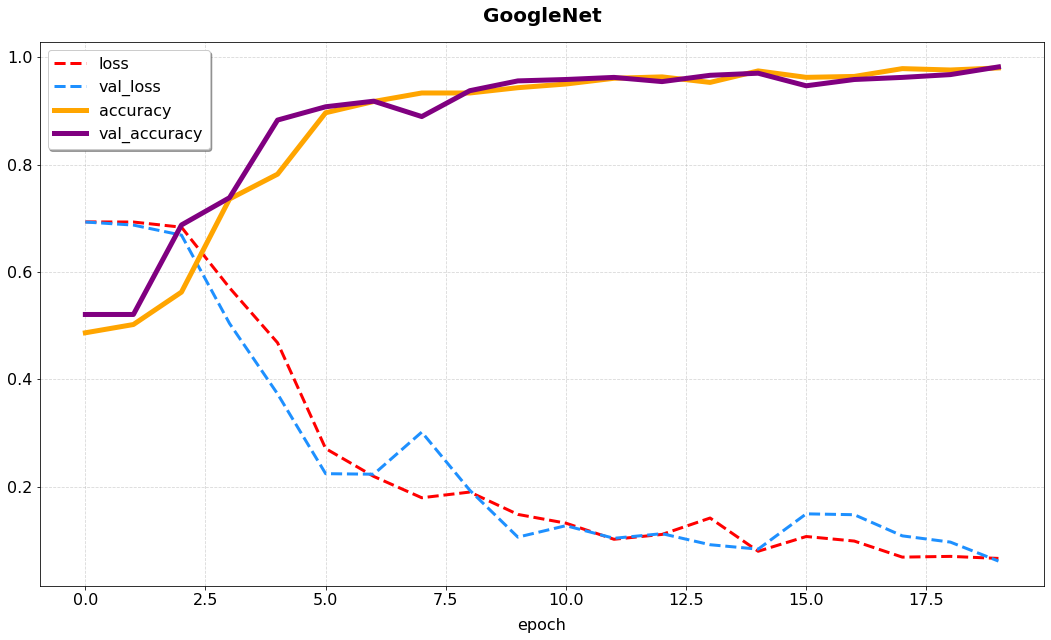

In [ ]:
plt.figure(figsize=(18,10))

plt.plot(GoogleNet_history.history['loss'], '--', c = 'red', label = 'loss', linewidth = 3)
plt.plot(GoogleNet_history.history['val_loss'], '--', c = 'dodgerblue', label = 'val_loss', linewidth = 3)
plt.plot(GoogleNet_history.history['accuracy'], c='orange',label = 'accuracy', linewidth = 5)
plt.plot(GoogleNet_history.history['val_accuracy'],c='purple',label = 'val_accuracy', linewidth = 5)


plt.legend(['loss', 'val_loss','accuracy','val_accuracy'],shadow = True, loc='best',fontsize = 16)
plt.title('GoogleNet', fontdict=font1, pad = 20)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

In [ ]:
# gg_model 모델 평가
(GoogleNet_model_val_loss, GoogleNet_model_model_val_accuracy) = GoogleNet_model.evaluate(val_set, steps=800//batch_size, verbose=1)
print('Test loss:', GoogleNet_model_val_loss)
print('Test accuracy:', GoogleNet_model_model_val_accuracy*100)

12/12 [==============================] - 6s 353ms/step - loss: 0.1047 - accuracy: 0.9766
Test loss: 0.10465335100889206
Test accuracy: 97.65625


In [ ]:
# test 데이터에 대한 최종 예측
# 실제로 예측하고 그 출력은 입력 데이터에서 예측 한 목표 값

pred = GoogleNet_model.predict(image, steps=800//batch_size, verbose=1)
test_pred = np.rint(pred).flatten()

print(test_pred[:10],test_pred.shape,sep='\n')

12/12 [==============================] - 5s 183ms/step
[1. 0. 0. 1. 1. 1. 1. 0. 1. 1.]
(800,)


[[394   9]
 [  6 391]]


[Text(0, 0.5, 'ambulance'), Text(0, 1.5, 'non_ambulance')]

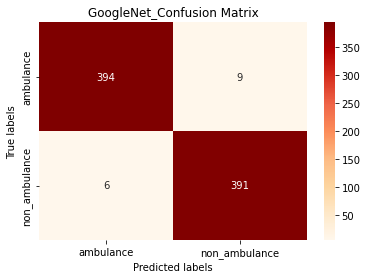

In [ ]:
matrix = confusion_matrix(test_pred, label)
print(matrix)

ax = plt.subplot()
sns.heatmap(matrix, annot=True, ax=ax, fmt='g', cmap='OrRd')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('GoogleNet_Confusion Matrix')
labels=['ambulance','non_ambulance']
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [ ]:
TP = matrix[0][0]
FP = matrix[0][1]
FN = matrix[1][0]
TN = matrix[1][1]

accuracy = (TP+TN)/(TP+FN+FP+TN)
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = (2*precision*recall)/(precision+recall)
specificity = TN/(FP+TN)

print('정확도:', round(accuracy,6))
print('정밀도:', round(precision,6))
print('재현율:', round(recall,6))
print('특이도:', round(specificity,6))
print('f1-score:', round(f1_score,6))

정확도: 0.98125
정밀도: 0.977667
재현율: 0.985
특이도: 0.9775
f1-score: 0.98132


AUC:  0.9812770718352907


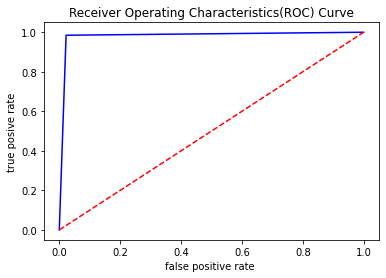

In [ ]:
# roc곡선 그리기

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test_pred,label)
print('AUC: ',auc)

# roc curve 함수 정의
def plot_roc_curve(specificity, recall): 
    plt.plot(specificity,recall, color='blue', label="ROC")
    plt.plot([0,1],[0,1], color='red', linestyle="--")
    plt.xlabel("false positive rate ")
    plt.ylabel("true posive rate")
    plt.title("Receiver Operating Characteristics(ROC) Curve")
    plt.legend
    plt.show()

specificity, recall, thresholds= roc_curve(test_pred, label)
plot_roc_curve(specificity, recall)

### 모델 비교

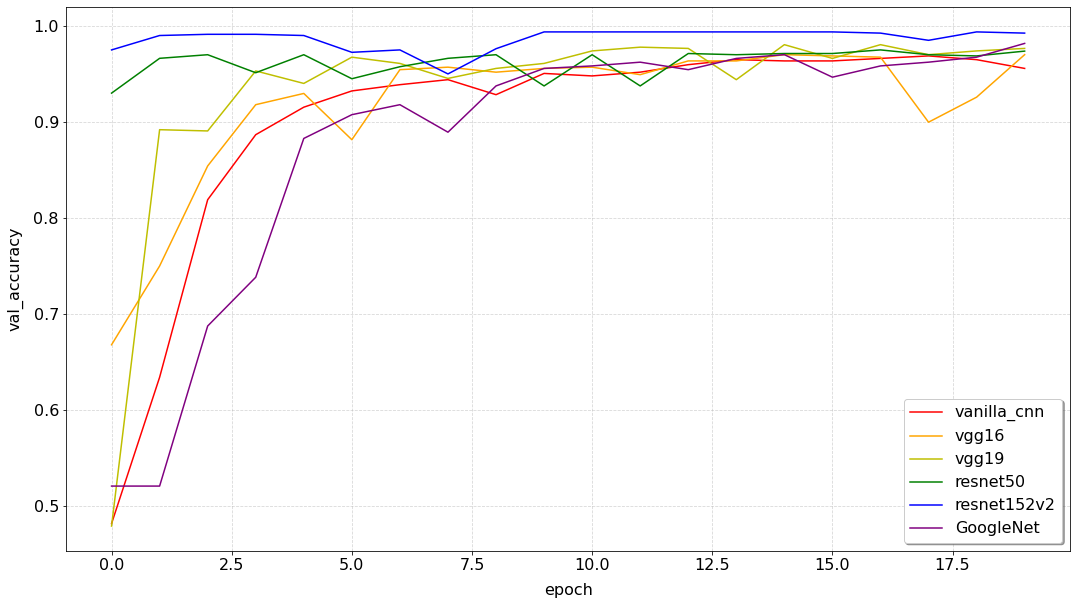

In [ ]:
plt.figure(figsize=(18,10))

plt.plot(vanilla_cnn_history.history['val_accuracy'],c='r',label = 'vanilla_cnn')
plt.plot(vgg16_history.history['val_accuracy'],c='orange',label = 'vgg16')
plt.plot(vgg19_history.history['val_accuracy'],c='y',label = 'vgg19')
plt.plot(resnet50_history.history['val_accuracy'],c='g',label = 'resnet50')
plt.plot(resnet152v2_history.history['val_accuracy'],c='b',label = 'resnet152v2')
plt.plot(GoogleNet_history.history['val_accuracy'],c='purple',label = 'GoogleNet')

plt.legend(['vanilla_cnn', 'vgg16','vgg19','resnet50','resnet152v2','GoogleNet'],shadow = True, loc='best',fontsize = 16)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.ylabel('val_accuracy', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

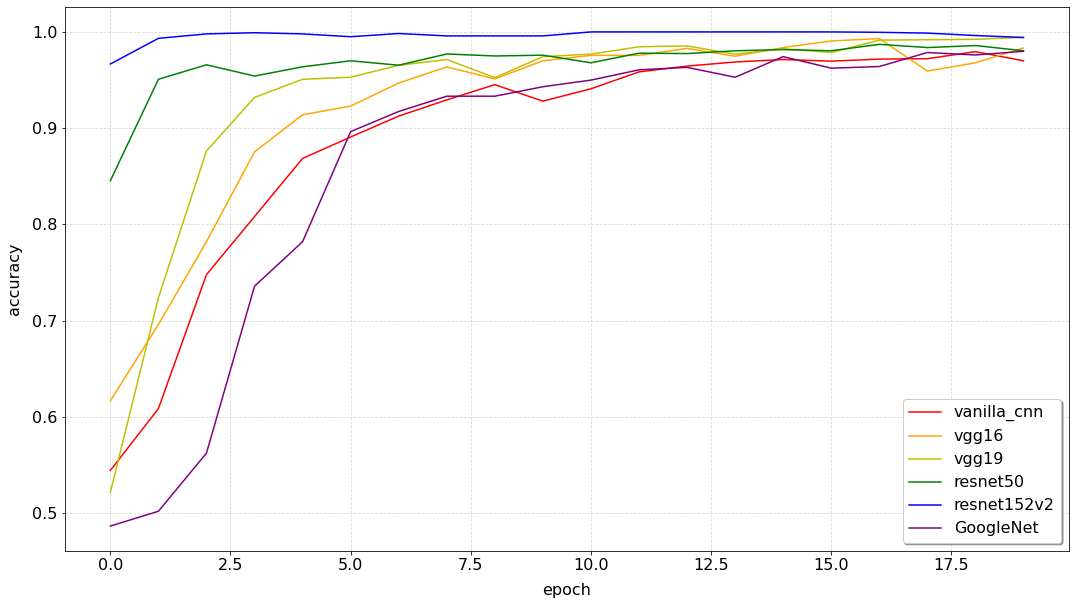

In [ ]:
plt.figure(figsize=(18,10))

plt.plot(vanilla_cnn_history.history['accuracy'],c='r',label = 'vanilla_cnn')
plt.plot(vgg16_history.history['accuracy'],c='orange',label = 'vgg16')
plt.plot(vgg19_history.history['accuracy'],c='y',label = 'vgg19')
plt.plot(resnet50_history.history['accuracy'],c='g',label = 'resnet50')
plt.plot(resnet152v2_history.history['accuracy'],c='b',label = 'resnet152v2')
plt.plot(GoogleNet_history.history['accuracy'],c='purple',label = 'GoogleNet')

plt.legend(['vanilla_cnn', 'vgg16','vgg19','resnet50','resnet152v2','GoogleNet'],shadow = True, loc='best',fontsize = 16)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.ylabel('accuracy', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

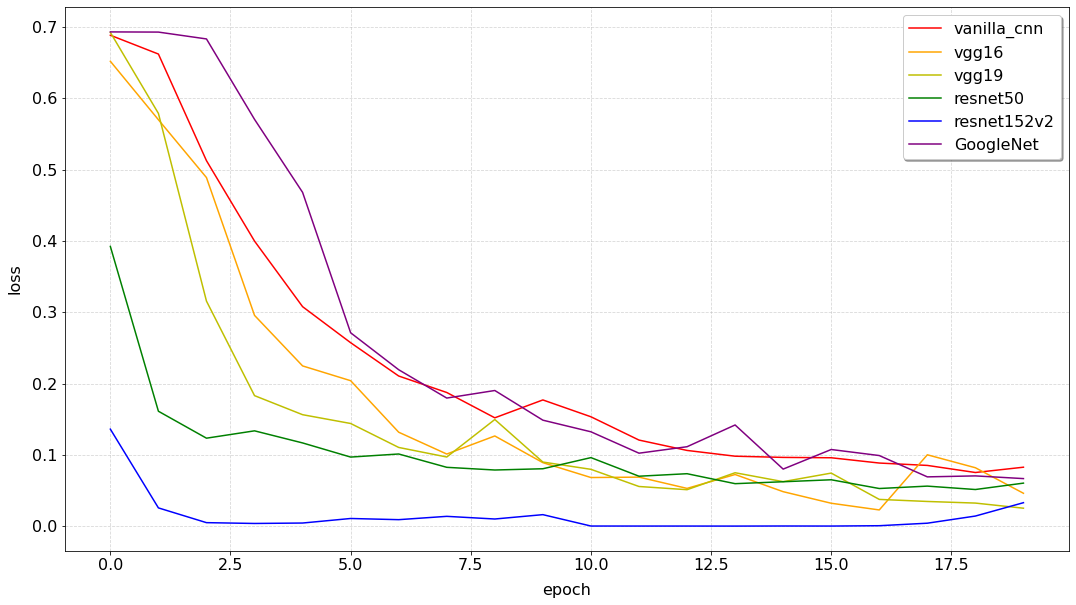

In [ ]:
plt.figure(figsize=(18,10))

plt.plot(vanilla_cnn_history.history['loss'],c='r',label = 'vanilla_cnn')
plt.plot(vgg16_history.history['loss'],c='orange',label = 'vgg16')
plt.plot(vgg19_history.history['loss'],c='y',label = 'vgg19')
plt.plot(resnet50_history.history['loss'],c='g',label = 'resnet50')
plt.plot(resnet152v2_history.history['loss'],c='b',label = 'resnet152v2')
plt.plot(GoogleNet_history.history['loss'],c='purple',label = 'GoogleNet')

plt.legend(['vanilla_cnn', 'vgg16','vgg19','resnet50','resnet152v2','GoogleNet'],shadow = True, loc='best',fontsize = 16)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.ylabel('loss', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()

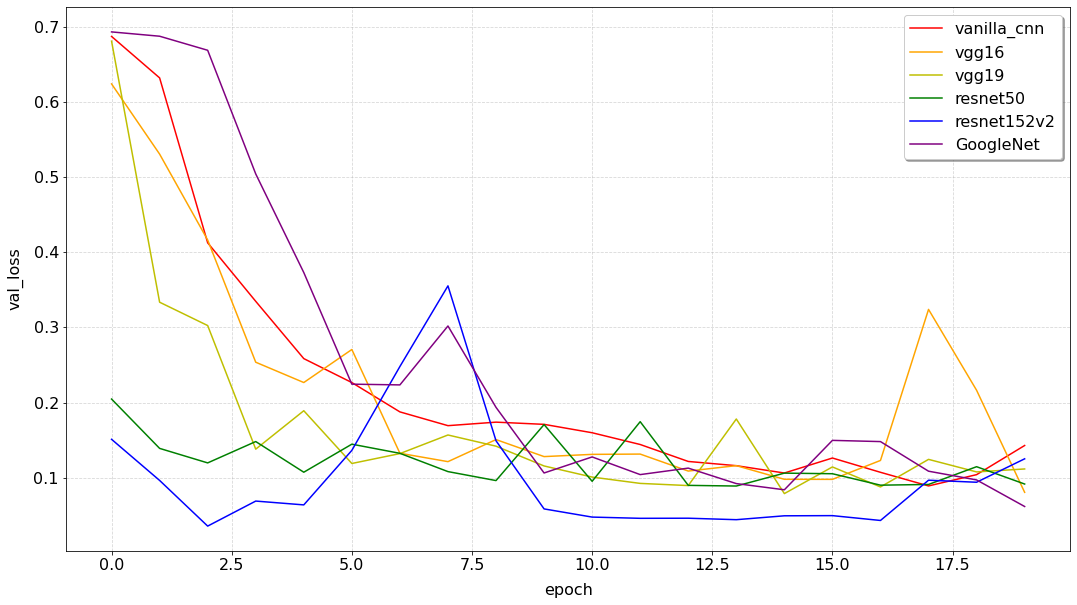

In [ ]:
plt.figure(figsize=(18,10))

plt.plot(vanilla_cnn_history.history['val_loss'],c='r',label = 'vanilla_cnn')
plt.plot(vgg16_history.history['val_loss'],c='orange',label = 'vgg16')
plt.plot(vgg19_history.history['val_loss'],c='y',label = 'vgg19')
plt.plot(resnet50_history.history['val_loss'],c='g',label = 'resnet50')
plt.plot(resnet152v2_history.history['val_loss'],c='b',label = 'resnet152v2')
plt.plot(GoogleNet_history.history['val_loss'],c='purple',label = 'GoogleNet')

plt.legend(['vanilla_cnn', 'vgg16','vgg19','resnet50','resnet152v2','GoogleNet'],shadow = True, loc='best',fontsize = 16)
plt.xlabel('epoch', fontdict=font2, labelpad=10)
plt.ylabel('val_loss', fontdict=font2, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True, alpha=0.5, linestyle='--')
plt.show()